The notebook aims to construct an XGBoost Model for modeling the Probability of Default.

# 0. Import Libraries


In [1]:
# === Standard libraries ===

import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Global Functions ==
from functions import *
import math


# === Spark Session & Functions ===
from init_spark import start_spark

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
    FloatType,
    LongType,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# === Machine Learning ===
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

# == Optbinning ==
from optbinning import OptimalPWBinning


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

# == XGBoost ==
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import xgboost as xgb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/04 11:21:18 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/0

4.0.0


In [2]:
# -----------------
# Global Variables
# -----------------

# == 1. Remove all existing runs every time I run this notebook
NOTEBOOK_RUN_NAME = "XG Boost"
MODEL_NAME = "XGBoost"
api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [3]:
# -----------------
# Global Functions
# -----------------


def train_test_split_oot(pdf):
    """Sorts Pandas Dataframe & Conducts 80-20 OOT Split on Pandas Dataframe"""
    pdf_sorted = pdf.sort_values("issue_d", ascending=True)
    split_idx = int(len(pdf_sorted) * 0.8)
    train_pdf = pdf_sorted.iloc[:split_idx]
    test_pdf = pdf_sorted.iloc[split_idx:]

    display(train_pdf.head())
    display(test_pdf.head())

    return train_pdf, test_pdf

In [4]:
# ------------------------------------
# Reading from Medallion Data Pipeline
# ------------------------------------

df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

df.limit(10).toPandas()

25/09/04 11:21:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,60951212,5000.0,5000.0,36,12.29,166.77,C,2,RENT,30575.57,...,100.0,0.0,1.0,0.0,46170.0,22243.0,10100.0,27370.0,14,672.0
1,60175755,8825.0,8825.0,36,27.31,361.76,G,10,MORTGAGE,26000.00,...,78.9,0.0,0.0,0.0,27249.0,18910.0,300.0,25949.0,11,672.0
2,60801386,12000.0,12000.0,36,9.99,387.15,B,3,MORTGAGE,75000.00,...,94.1,0.0,0.0,0.0,171957.0,8058.0,3500.0,11157.0,9,692.0
3,60705217,8000.0,8000.0,36,9.17,255.04,B,2,RENT,30000.00,...,90.9,0.0,1.0,0.0,54330.0,41233.0,15000.0,39330.0,10,667.0
4,60676934,8000.0,8000.0,36,7.26,247.97,A,10,MORTGAGE,120000.00,...,89.7,0.0,0.0,0.0,8600.0,4234.0,1000.0,4500.0,30,702.0
5,60536817,30000.0,30000.0,60,24.99,880.37,F,4,MORTGAGE,65000.00,...,85.7,42.9,0.0,0.0,48537.0,37527.0,0.0,46037.0,14,687.0
6,59080673,4650.0,4650.0,36,16.99,165.77,D,6,MORTGAGE,80024.00,...,55.0,42.9,1.0,0.0,50604.0,42187.0,0.0,48004.0,24,662.0
7,60376087,12000.0,12000.0,36,15.61,419.58,D,6,OWN,24000.00,...,57.1,100.0,0.0,0.0,5200.0,3506.0,3500.0,0.0,22,662.0
8,60800328,6000.0,6000.0,36,5.32,180.69,A,6,RENT,45000.00,...,100.0,0.0,0.0,0.0,39923.0,23074.0,18500.0,21423.0,17,757.0
9,59829795,15000.0,15000.0,36,8.18,471.30,B,6,OWN,43200.00,...,81.2,0.0,0.0,0.0,259335.0,11865.0,1100.0,21464.0,15,737.0


In [5]:
# ---------------------------
# Convert to Pandas Dataframe
# ---------------------------
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf = df.toPandas()

In [6]:
# ---------------------------------------------
# Data Leakage Removal & Useless Column Removal
# ---------------------------------------------

post_loan_origination_features = [
    "funded_amnt",
    "out_prncp",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
    "tot_coll_amt",
    "last_fico_range_high",
    "last_fico_range_low",
]


# == total_pymnt_inv, total_rec_prncp_inv, total_rec_int_inv, out_prncp_inv removed prvsly ==


pdf = pdf.drop(columns=post_loan_origination_features)
print("✅ Post Loan Origination Features Dropped ...")

# == Assert none of these columns are in pdf.columns ==
assert not any(
    col in pdf.columns for col in post_loan_origination_features
), f"Some post-loan origination features are still present in pdf: {set(pdf.columns) & set(post_loan_origination_features)}"

✅ Post Loan Origination Features Dropped ...


Base Model Performance can be found in Wandb as shown below.

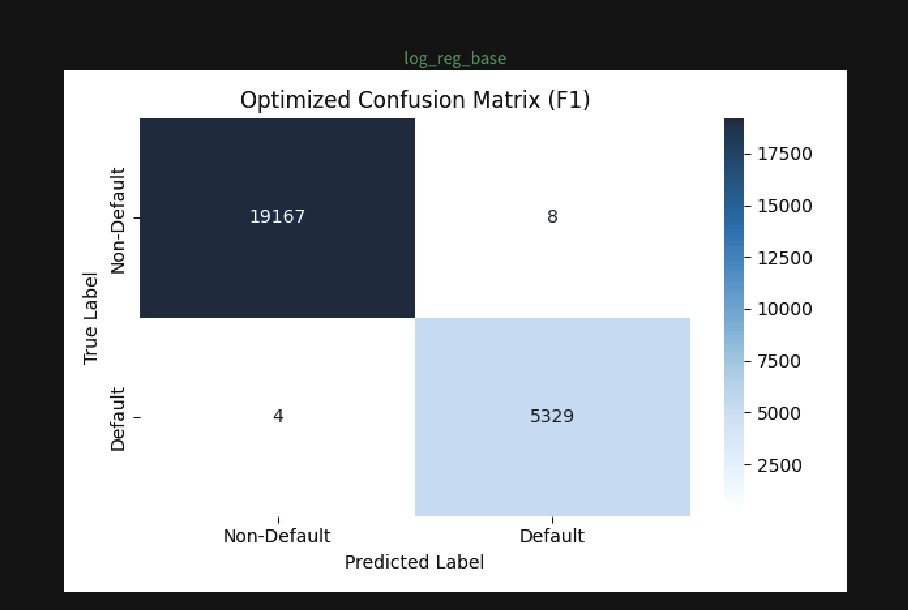


In [7]:
f"Current Dataset has {pdf.shape[0]} rows, {pdf.shape[1]} columns"

'Current Dataset has 1339155 rows, 63 columns'

# 1. Data Inspection & Preparation


In [8]:
pdf.head()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,60951212,5000.0,36,12.29,166.77,C,2,RENT,30575.57,Verified,...,100.0,0.0,1.0,0.0,46170.0,22243.0,10100.0,27370.0,14,672.0
1,60175755,8825.0,36,27.31,361.76,G,10,MORTGAGE,26000.00,Verified,...,78.9,0.0,0.0,0.0,27249.0,18910.0,300.0,25949.0,11,672.0
2,60801386,12000.0,36,9.99,387.15,B,3,MORTGAGE,75000.00,Source Verified,...,94.1,0.0,0.0,0.0,171957.0,8058.0,3500.0,11157.0,9,692.0
3,60705217,8000.0,36,9.17,255.04,B,2,RENT,30000.00,Verified,...,90.9,0.0,1.0,0.0,54330.0,41233.0,15000.0,39330.0,10,667.0
4,60676934,8000.0,36,7.26,247.97,A,10,MORTGAGE,120000.00,Verified,...,89.7,0.0,0.0,0.0,8600.0,4234.0,1000.0,4500.0,30,702.0


In [9]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339155 entries, 0 to 1339154
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1339155 non-null  int32  
 1   loan_amnt                   1339155 non-null  float64
 2   term                        1339155 non-null  int32  
 3   int_rate                    1339155 non-null  float64
 4   installment                 1339155 non-null  float64
 5   grade                       1339155 non-null  object 
 6   emp_length                  1339155 non-null  int32  
 7   home_ownership              1339155 non-null  object 
 8   annual_inc                  1339155 non-null  float64
 9   verification_status         1339155 non-null  object 
 10  issue_d                     1339155 non-null  object 
 11  default_status              1339155 non-null  int32  
 12  dti                         1339155 non-null  float64
 1

In [10]:
pd.set_option("display.max_columns", None)
pdf.describe(include="all")

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
count,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1339155,1.339155e+06,1339155,1.339155e+06,1339155,1339155,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1339155,1.339155e+06,1339155,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06,1.339155e+06
unique,NaN,NaN,NaN,NaN,NaN,7,NaN,4,NaN,3,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,B,NaN,MORTGAGE,NaN,Source Verified,2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,w,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,391509,NaN,662684,NaN,519407,48731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780537,NaN,1313845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.632851e+07,1.442150e+04,4.178889e+01,1.322971e+01,4.380696e+02,NaN,5.968442e+00,NaN,7.621225e+04,NaN,NaN,1.994213e-01,1.828356e+01,3.178213e-01,6.562467e-01,1.161260e+01,2.159406e-01,1.623734e+04,5.163071e+01,2.500765e+01,NaN,1.718770e-02,NaN,5.046466e-03,1.379060e+05,3.240371e+04,4.677548e+00,1.311484e+04,9.971441e+03,5.992143e+01,9.072886e-03,1.479878e+01,1.260435e+02,1.806221e+02,1.276385e+01,7.682989e+00,1.647555e+00,2.324856e+01,6.486867e+00,4.843748e-01,3.616042e+00,5.621630e+00,4.713136e+00,8.057852e+00,8.488646e+00,8.234527e+00,1.455565e+01,5.573077e+00,1.163115e+01,7.504732e-04,3.243837e-03,8.446072e-02,2.174523e+00,9.435945e+01,4.487755e+01,1.348597e-01,5.222622e-02,1.711557e+05,4.919869e+04,2.143735e+04,4.158066e+04,1.580248e+01,6.982223e+02
std,3.836608e+07,8.713596e+03,1.026753e+01,4.766808e+00,2.613672e+02,NaN,3.581814e+00,NaN,6.908876e+04,NaN,NaN,3.995655e-01,1.116332e+01,8.781153e-01,9.383133e-01,5.471754e+00,6.026137e-01,2.226833e+04,2.435713e+01,1.199944e+01,NaN,1.471513e-01,NaN,7.707780e-02,1.539257e+05,3.575374e+04,3.133656e+00,1.573651e+04,1.505948e+04,2.758024e+01,1.098098e-01,8.035577e+02,5.015356e+01,9.221585e+01,1.577746e+01,8.476042e+00,1.968897e+00,2.998603e+01,5.486424e+00,1.296927e+00,2.195616e+00,3.220391e+00,2.893960e+00,4.686953e+00,7.205238e+00,4.447356e+00,7.921659e+00,3.135429e+00,5.366974e+00,2.917991e-02,6.066191e-02,4.919013e-01,1.799361e+00,8.556115e+00,3.511154e+01,3.784629e-01,3.982823e-01,1.739222e+05,4.690153

In [11]:
# ---------------------
# Missing Values Check
# ---------------------
pd.set_option("display.max_rows", None)
display(pdf.isnull().sum())

id                            0
loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
default_status                0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
collections_12_mths_ex_med    0
application_type              0
acc_now_delinq                0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
chargeoff_within_12_mths      0
delinq_a

### 1.1 Outlier Inspection


In [12]:
# --------------------------
# Outlier Handling Functions
# --------------------------


def compute_outlier_pct_pd(s: pd.Series) -> float:
    """Return % of outliers in a pandas Series using IQR rule."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_count = ((s < lower) | (s > upper)).sum()
    return outlier_count / len(s) * 100


def boxplots_numeric_columns(df, max_cols=3):
    numeric_cols = sorted(df.select_dtypes(include=["number"]).columns.tolist())

    n_cols = max_cols
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f"{col}")
        axes[i].set_ylabel(col)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def inspect_outliers_pd(
    df: pd.DataFrame,
    columns: list,
    sample_size: int = 5,
    method: str = "iqr",  # "iqr" or "percentile"
    lower_pct: float = 0.01,
    upper_pct: float = 0.99,
):
    for col in columns:
        print(f"\n📊 Inspecting Outliers for Column: `{col}`")
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        if s.empty:
            print("⚠️ No numeric data; skipping.")
            continue

        if method.lower() == "iqr":
            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            print(f"IQR Method | Q1={q1:.3f}, Q3={q3:.3f}, IQR={iqr:.3f}")
            print(f"Lower Bound={lower:.3f}, Upper Bound={upper:.3f}")
        else:
            q_low, q_high = s.quantile([lower_pct, upper_pct])
            lower, upper = float(q_low), float(q_high)
            print(
                f"Percentile Method | Lower p{int(lower_pct*100)}={lower:.3f}, Upper p{int(upper_pct*100)}={upper:.3f}"
            )

        # Separate masks
        lower_mask = s < lower
        upper_mask = s > upper

        outlier_count = lower_mask.sum() + upper_mask.sum()
        outlier_pct = round(outlier_count / len(s) * 100, 2)
        print(f"Outlier Count: {outlier_count} ({outlier_pct}% of valid {len(s)})")

        if upper_mask.any():
            print(f"\n🔼 Top Outliers (>{upper:.3f}):")
            print(s[upper_mask].sort_values(ascending=False).head(sample_size))

        if lower_mask.any():
            print(f"\n🔽 Bottom Outliers (<{lower:.3f}):")
            print(s[lower_mask].sort_values(ascending=True).head(sample_size))
        elif not (lower_mask.any() or upper_mask.any()):
            print("✅ No outliers by the chosen rule.")


def plot_kde_pdf(df, feature_list, bins=50, kde=False, cols=3, figsize=(18, 5)):
    rows = math.ceil(len(feature_list) / cols)
    plt.figure(figsize=(figsize[0], figsize[1] * rows))

    for i, col in enumerate(feature_list):
        ax = plt.subplot(rows, cols, i + 1)
        sns.histplot(df[col], bins=bins, kde=kde, ax=ax, color="skyblue")
        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel("Count", fontsize=9)

    plt.tight_layout()
    plt.show()

In [13]:
# -----------------------
# OOT Train-Test Split
# -----------------------
train_pdf, test_pdf = train_test_split_oot(pdf)

train_pdf_copy = train_pdf.copy()
test_pdf_copy = test_pdf.copy()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
687631,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
687652,76597,5000.0,36,9.01,159.03,B,1,MORTGAGE,250000.0,Not Verified,2007-07-01,0,10.00,2,0,5,0,14354.0,36.6,7,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0
687661,106360,2700.0,36,15.96,94.88,F,1,RENT,52200.0,Not Verified,2007-07-01,0,12.57,0,1,12,0,3075.0,92.3,13,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,627.0
687660,90665,8500.0,36,10.28,275.38,C,3,RENT,18000.0,Not Verified,2007-07-01,0,6.40,1,1,6,0,8847.0,26.9,9,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,20,692.0
687659,90966,5000.0,36,7.43,155.38,A,8,MORTGAGE,150000.0,Not Verified,2007-07-01,0,0.00,0,0,2,0,6053.0,19.5,19,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,19,777.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
375298,90239923,9600.0,36,13.49,325.74,C,0,RENT,30000.0,Source Verified,2016-10-01,1,31.68,0,0,12,0,3965.0,37.4,16,w,0,Individual,0,42248.0,10600.0,9.0,3521.0,414.0,82.0,0.0,0.0,101.0,34.0,1.0,1.0,0.0,7.0,2.0,0.0,2.0,4.0,2.0,2.0,6.0,9.0,9.0,4.0,12.0,0.0,0.0,0.0,6.0,100.0,50.0,0.0,0.0,55622.0,42248.0,2300.0,45022.0,10,702.0
375297,90936366,12500.0,36,12.79,419.92,C,10,RENT,46000.0,Verified,2016-10-01,1,15.37,0,0,9,1,11432.0,69.3,23,w,0,Individual,0,14491.0,16500.0,6.0,1610.0,1168.0,90.7,0.0,0.0,113.0,131.0,8.0,8.0,0.0,8.0,8.0,0.0,4.0,4.0,4.0,6.0,14.0,6.0,9.0,4.0,9.0,0.0,0.0,0.0,3.0,100.0,100.0,1.0,0.0,21610.0,14491.0,12600.0,5110.0,10,672.0
375296,91197158,20000.0,60,8.59,411.20,A,3,MORTGAGE,191000.0,Not Verified,2016-10-01,0,15.33,0,0,11,0,28679.0,42.3,28,w,0,Individual,0,349645.0,67800.0,6.0,31786.0,33970.0,38.0,0.0,0.0,136.0,188.0,10.0,10.0,4.0,10.0,5.0,0.0,3.0,4.0,5.0,7.0,10.0,7.0,13.0,4.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,462051.0,67730.0,54800.0,67754.0,21,752.0
375295,90264888,5050.0,36,10.99,165.31,B,3,MORTGAGE,103000.0,Not Verified,2016-10-01,0,15.11,0,0,21,0,10159.0,55.2,35,w,0,Individual,0,251864.0,18400.0,4.0,11994.0,6053.0,60.2,0.0,0.0,147.0,111.0,2.0,2.0,2.0,2.0,15.0,0.0,3.0,4.0,3.0,3.0,27.0,5.0,6.0,4.0,21.0,0.0,0.0,0.0,1.0,91.4,66.7,0.0,0.0,250141.0,113154.0,15200.0,89368.0,12,692.0
375294,90156458,11200.0,60,22.74,314.07,E,0,RENT,36000.0,Source Verified,2016-10-01,1,17.80,0,1,17,0,3517.0,52.5,19,w,0,Individual,0,69901.0,6700.0,5.0,4112.0,258.0,82.8,0.0,0.0,62.0,45.0,4.0,4.0,0.0,17.0,0.0,0.0,2.0,4.0,2.0,2.0,13.0,5.0,6.0,4.0,17.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,77642.0,69901.0,1500.0,70942.0,5,697.0


In [14]:
# -----------------------
# Inspect Outlier %
# -----------------------

print("❌ Outlier Percentage:")
for feature in train_pdf_copy.columns:
    outlier_pct = round(compute_outlier_pct_pd(train_pdf_copy[feature]), 2)
    if outlier_pct > 0:
        print(f"{feature}: {outlier_pct}")

❌ Outlier Percentage:
loan_amnt: 0.15
term: 24.11
int_rate: 1.47
installment: 2.9
annual_inc: 4.62
default_status: 19.49
dti: 0.16
delinq_2yrs: 19.44
inq_last_6mths: 5.69
open_acc: 3.29
pub_rec: 16.52
revol_bal: 5.77
total_acc: 1.66
collections_12_mths_ex_med: 1.47
acc_now_delinq: 0.5
tot_cur_bal: 4.0
total_rev_hi_lim: 6.4
acc_open_past_24mths: 1.99
avg_cur_bal: 5.84
bc_open_to_buy: 9.41
chargeoff_within_12_mths: 0.8
delinq_amnt: 0.38
mo_sin_old_il_acct: 8.7
mo_sin_old_rev_tl_op: 3.56
mo_sin_rcnt_rev_tl_op: 8.3
mo_sin_rcnt_tl: 7.24
mort_acc: 1.44
mths_since_recent_bc: 9.84
mths_since_recent_inq: 3.82
num_accts_ever_120_pd: 22.16
num_actv_bc_tl: 1.94
num_actv_rev_tl: 5.37
num_bc_sats: 4.01
num_bc_tl: 4.54
num_il_tl: 5.62
num_op_rev_tl: 3.86
num_rev_accts: 2.42
num_rev_tl_bal_gt_0: 5.08
num_sats: 3.2
num_tl_120dpd_2m: 0.07
num_tl_30dpd: 0.33
num_tl_90g_dpd_24m: 5.49
num_tl_op_past_12m: 2.3
pct_tl_nvr_dlq: 6.72
pub_rec_bankruptcies: 11.89
tax_liens: 3.24
tot_hi_cred_lim: 3.96
total_bal_ex

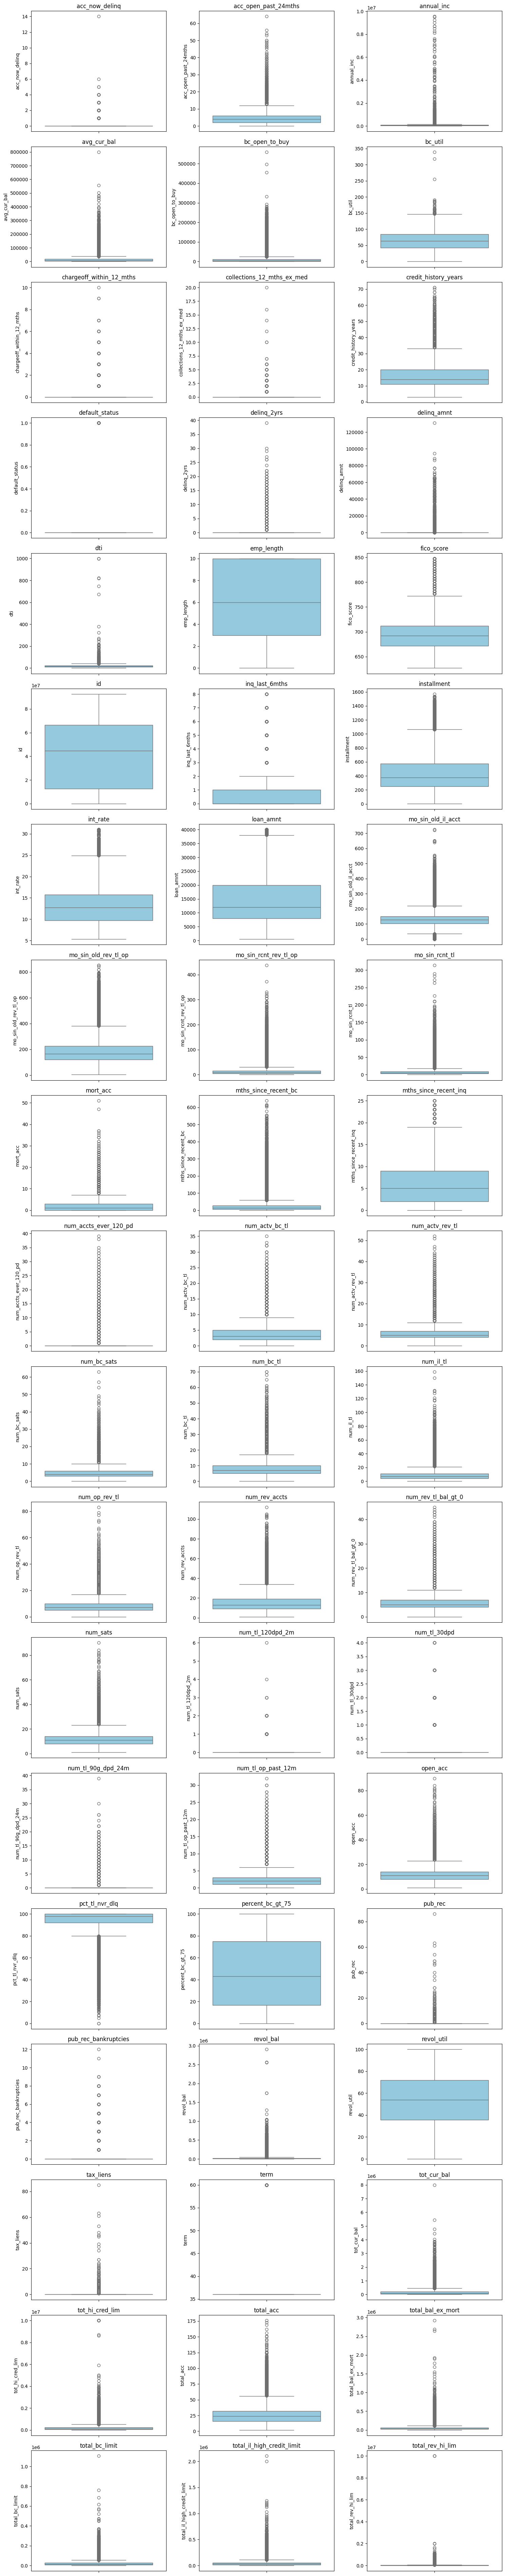

In [15]:
# -----------------------
# Inspect Distributions
# -----------------------
boxplots_numeric_columns(train_pdf_copy)

In [16]:
# ----------------------
# Check Outlier Values
# ----------------------
outlier_columns = sorted(list(train_pdf_copy.columns))
inspect_outliers_pd(df=train_pdf_copy, columns=outlier_columns, method="iqr")


📊 Inspecting Outliers for Column: `acc_now_delinq`
IQR Method | Q1=0.000, Q3=0.000, IQR=0.000
Lower Bound=0.000, Upper Bound=0.000
Outlier Count: 5341 (0.5% of valid 1071324)

🔼 Top Outliers (>0.000):
515570    14
581066     6
837200     5
873950     5
67781      4
Name: acc_now_delinq, dtype: int32

📊 Inspecting Outliers for Column: `acc_open_past_24mths`
IQR Method | Q1=2.000, Q3=6.000, IQR=4.000
Lower Bound=-4.000, Upper Bound=12.000
Outlier Count: 21348 (1.99% of valid 1071324)

🔼 Top Outliers (>12.000):
115077     64.0
257236     56.0
284190     54.0
1077924    53.0
115052     50.0
Name: acc_open_past_24mths, dtype: float64

📊 Inspecting Outliers for Column: `annual_inc`
IQR Method | Q1=45000.000, Q3=90000.000, IQR=45000.000
Lower Bound=-22500.000, Upper Bound=157500.000
Outlier Count: 49527 (4.62% of valid 1071324)

🔼 Top Outliers (>157500.000):
247828     9550000.0
637008     9500000.0
258156     9225000.0
128963     9000000.0
1151867    8706582.0
Name: annual_inc, dtype: float

Invalid Placeholders result in the lack of data integrity, and may cause our challenger model's performance to suffer. As such, let's create a `InvalidValueHandler` class to be included in our `sklearn` `Pipeline` object later on.


In [17]:
# ---------------------------------
# ⚠️ Detect & Remove Invalid Values
# ---------------------------------

from sklearn.base import BaseEstimator, TransformerMixin

# [Min Value , Max)
valid_values_mapping = {
    "dti": [0, 101],
    "fico_score": [300, 851],
    "tot_hi_cred_lim": [0, 9999999.0],
    "mo_sin_old_il_acct": [0, 999],
    "mo_sin_old_rev_tl_op": [0, 999],
    "total_rev_hi_lim": [0, 9_999_999],
}

print(f"Initial Row Count: {train_pdf_copy['id'].count()}")


# == Defining Classes to put in sklearn Pipeline Object ==
class InvalidValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, valid_values_dict):
        self.ref_dict = valid_values_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        valid_mask = pd.Series(True, index=X_transformed.index)  # Start with all True

        for key, value in self.ref_dict.items():
            min_val = value[0]
            max_val = value[1] - 1

            # == Keep updating boolean mask ==
            valid_mask &= valid_mask & (
                (X_transformed[key] >= min_val) & (X_transformed[key] <= max_val)
            )

        X_transformed = X_transformed.loc[valid_mask, :].copy()

        return X_transformed


invalid_values_handler = InvalidValueHandler(valid_values_mapping)
train_pdf_copy = invalid_values_handler.fit_transform(train_pdf_copy)
print(f"Final Row Count: {train_pdf_copy['id'].count()}")

Initial Row Count: 1071324
Final Row Count: 1071254


### 1.2 Remove Low Variance Features

Furthermore, it is useful to remove features of low variance, since 1 distinct value takes up majority of the data points. Though our XGBoost Decision Trees won't split on features with no variability, it is still good practice to drop these features, since they add no information.


In [18]:
def plot_low_variance_pies(df: pd.DataFrame, threshold: float = 0.95) -> list:
    """
    Find low-variance features and plot their value distribution as pie charts
    in a grid of subplots.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    threshold : float, default=0.95
        Proportion cutoff for flagging low-variance features.

    Returns
    -------
    low_var_cols : list
        List of low-variance feature names.
    """
    # Find low variance columns
    low_var_cols = [
        col
        for col in df.columns
        if df[col].value_counts(dropna=False, normalize=True).iloc[0] >= threshold
    ]

    if not low_var_cols:
        print(f"No low-variance features found with threshold {threshold}.")
        return []

    # Setup subplot grid
    sns.set_theme(style="whitegrid")  # or another preferred style
    n = len(low_var_cols)
    ncols = 3  # adjust grid size if needed
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()

    # Plot pies
    for i, col in enumerate(low_var_cols):
        # Custom autopct: only show percent if > 1%, else blank
        def autopct_fmt(pct):
            return f"{pct:.1f}%" if pct > 1 else ""

        df[col].value_counts(dropna=False).plot.pie(
            ax=axes[i],
            autopct=autopct_fmt,  # Key change: formatted autopct
            startangle=90,
            counterclock=False,
            labels=None,  # Key change: suppress slice labels
        )
        axes[i].set_title(f"{col} (low variance)")
        axes[i].set_ylabel("")

    # Hide unused subplots
    for j in range(len(low_var_cols), len(axes)):
        axes[j].axis("off")

    plt.title("Low Variance Features")
    plt.tight_layout()
    plt.show()

    return low_var_cols

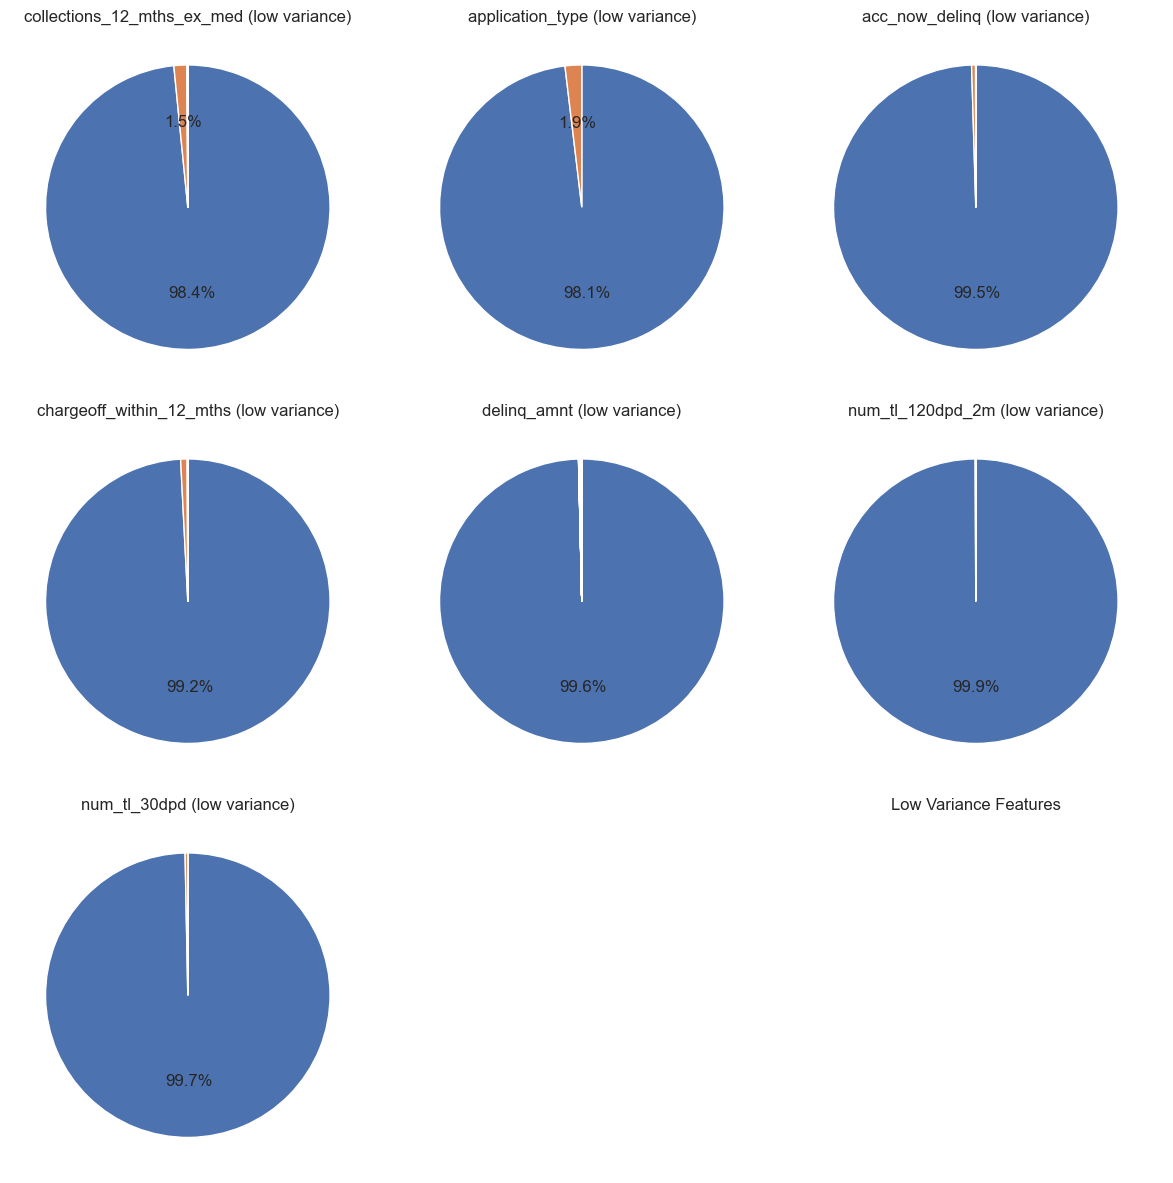

In [19]:
low_var_cols = plot_low_variance_pies(pdf, threshold=0.98)

In [20]:
# ----------------------------------------------
# Construct ZeroVarianceDropper: Remove Features
# ----------------------------------------------


class ZeroVarianceColumnDropper(BaseEstimator, TransformerMixin):
    """
    Drops specified columns from a pandas DataFrame.
    """

    def __init__(self, columns=None):
        self.columns = columns if columns is not None else []

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")


zero_var_columns = [
    "acc_now_deliinq",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
]

print(f"Original Shape: {train_pdf_copy.shape}")
dropper = ZeroVarianceColumnDropper(columns=low_var_cols)
train_pdf_copy = dropper.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071254, 63)
Final Shape: (1071254, 56)


### 1.3 Skewness Transformation

Transformations of skewed features aren't typically needed for XGBoost, since XGBoost can handle skewed variables well (split on thresholds). However, we shall just inspect the skewness of our variables for formality. After running the cell below, it can be seen that many of our features are right skewed, just like many other financial datasets.


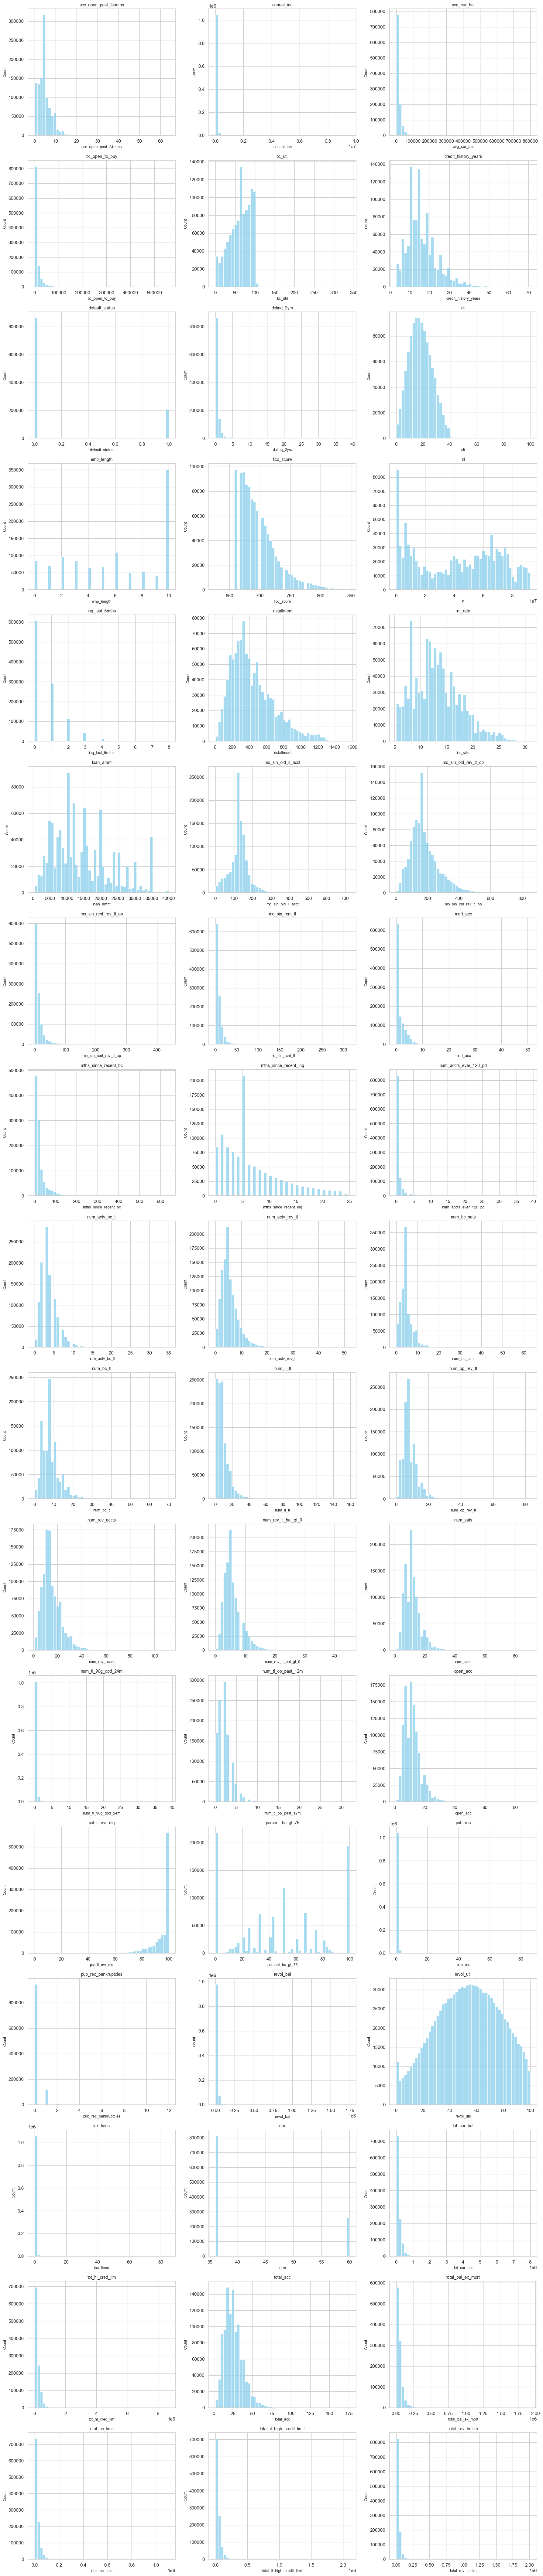

In [21]:
numeric_features = sorted(
    train_pdf_copy.select_dtypes(include="number").columns.tolist()
)
plot_kde_pdf(train_pdf_copy, numeric_features)

### 1.4 Categorical Encoding

In contrast to LightGBM (which shines when there are a lot of categorical features), it seems that our dataset has very few categorical features. Upon further inspection, it seems that although `term` & `emp_length` are `dtype=numeric`, `term` is a binary feature (36 vs 60), while `emp_length` has `10+`, which can mean a borrower is employed more than 10 years. Hence, they should be treated as categorical features instead. As such, we will be performing one-hot encoding / ordinal encoding for these features, since tree models have lesser multicollinearity concerns, like regression models.


In [22]:
# ----------------------------------------------
# Construct One Hot Encoder
# ----------------------------------------------


class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.columns_ = None  # will hold fitted dummy columns

    def fit(self, X, y=None):
        # Create dummies on fit to capture all dummy columns
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns, dtype="int")
        self.columns_ = X_dummies.columns
        return self

    def transform(self, X):
        # Create dummies on transform
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns)

        # Ensure all columns seen in fit are present, add missing with 0
        for col in self.columns_:
            if col not in X_dummies:
                X_dummies[col] = 0

        # Align columns order same as fit columns
        X_dummies = X_dummies[self.columns_]

        # Drop the original categorical columns from X and concatenate dummies
        X_remaining = X.drop(columns=self.columns)
        X_transformed = pd.concat(
            [X_remaining.reset_index(drop=True), X_dummies.reset_index(drop=True)],
            axis=1,
        )

        return X_transformed

In [23]:
category_columns = [
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "term",
]

print(f"Original Shape: {train_pdf_copy.shape}")
one_hot_encoder = CustomOneHotEncoder(category_columns)
train_pdf_copy = one_hot_encoder.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071254, 56)
Final Shape: (1071254, 63)


In [24]:
# ----------------------------------------------
# Ordinal Encoding for `grade`& 'emp_length`
# ----------------------------------------------


class GradeEmpLengthEncoder(BaseEstimator, TransformerMixin):
    """
    Ordinal encoding for 'grade' and 'emp_length'.
      - grade: A..G -> 1..7
      - emp_length: already int (0..10) -> keep as is
    """

    def __init__(self, grade_col="grade", emp_col="emp_length"):
        self.grade_col = grade_col
        self.emp_col = emp_col
        self.grade_map = {g: i + 1 for i, g in enumerate(list("ABCDEFG"))}

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        X = X.copy()
        # grade mapping
        if self.grade_col in X.columns:
            X[self.grade_col + "_ord"] = X[self.grade_col].map(self.grade_map)
        # emp_length already integer-coded
        if self.emp_col in X.columns:
            X[self.emp_col + "_ord"] = X[self.emp_col].astype(int)

        X = X.drop(columns=["grade", "emp_length"])
        return X


print(f"Original Shape: {train_pdf_copy.shape}")
grade_emp_length_encoder = GradeEmpLengthEncoder(
    grade_col="grade", emp_col="emp_length"
)
train_pdf_copy = grade_emp_length_encoder.fit_transform(train_pdf_copy)
print(f"Final Shape: {train_pdf_copy.shape}")

Original Shape: (1071254, 63)
Final Shape: (1071254, 63)


In [25]:
pd.set_option("display.max_columns", None)
train_pdf_copy.head()

,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0
1,76597,5000.0,9.01,159.03,250000.0,2007-07-01,0,10.00,2,0,5,0,14354.0,36.6,7,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0,True,False,False,False,True,False,False,True,False,True,False,2,1
2,106360,2700.0,15.96,94.88,52200.0,2007-07-01,0,12.57,0,1,12,0,3075.0,92.3,13,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,627.0,False,False,False,True,True,False,False,True,False,True,False,6,1
3,90665,8500.0,10.28,275.38,18000.0,2007-07-01,0,6.40,1,1,6,0,8847.0,26.9,9,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,20,692.0,False,False,False,True,True,False,False,True,False,True,False,3,3
4,90966,5000.0,7.43,155.38,150000.0,2007-07-01,0,0.00,0,0,2,0,6053.0,19.5,19,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,19,777.0,True,False,False,False,True,False,False,True,False,True,False,1,8


# 2. Feature Engineering


In [26]:
train_pdf_copy_feat_en = train_pdf_copy.copy()

In [27]:
# -----------------------------
# Interaction Feature Functions
# -----------------------------
def plot_default_rate_bars(df, features, target="default_status", q=4, ncols=3):
    n = len(features)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)

    # Pre-binning all columns at once (batch processing)
    binned = {f: pd.qcut(df[f], q=q, duplicates="drop") for f in features}

    # Grouping is still per-feature but binning overhead is cut
    for i, f in enumerate(features):
        ax = axes[i]
        bins = binned[f]
        default_rate = df.groupby(bins, observed=True)[target].mean()
        default_rate.plot(kind="bar", ax=ax)
        ax.set_title(f"Default Rate by {f} (q={q})")
        ax.set_ylabel("Default Rate")
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, features, target="default_status", cap_pct=0.99, ncols=3):
    n = len(features)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)

    # Process all capping in a single pass for feature columns
    capped_df = df.copy()
    for f in features:
        cap = capped_df[f].quantile(cap_pct)
        capped_df[f + "_cap"] = np.minimum(capped_df[f], cap)

    # Boxplot: now only plot with capped df
    for i, f in enumerate(features):
        ax = axes[i]
        sns.boxplot(
            x=target, y=f + "_cap", data=capped_df, ax=ax, hue=target, showfliers=False
        )
        ax.set_title(f"{f} (capped @{int(cap_pct*100)}th pct)")
        ax.set_xlabel(target)
        ax.set_ylabel(f)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

In [28]:
sorted(train_pdf_copy_feat_en.columns)

['acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'credit_history_years',
 'default_status',
 'delinq_2yrs',
 'dti',
 'emp_length_ord',
 'fico_score',
 'grade_ord',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'id',
 'initial_list_status_f',
 'initial_list_status_w',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'revol_util',
 'tax_liens',
 'term_36',
 'term_60',
 'tot_cur_bal',
 'tot_

In [29]:
# --------- tiny helper (vectorized, no Infs) ----------
def sdiv(num, den, eps=1e-6):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    n = num.to_numpy(dtype="float64")
    d = den.to_numpy(dtype="float64")
    out = np.full_like(d, np.nan, dtype="float64")
    np.divide(n, d, out=out, where=d > eps)  # only divide where safe
    return pd.Series(out, index=num.index)


# --------------------------------
# Creation of Interaction Features
# --------------------------------
train_pdf_copy_feat_en = train_pdf_copy_feat_en  # alias
eps = 1e-6

# precompute monthly income once
monthly_inc = train_pdf_copy_feat_en["annual_inc"] / 12

# Products

# == DTI ==
train_pdf_copy_feat_en["dti_emp_inter&"] = train_pdf_copy_feat_en[
    "dti"
] * train_pdf_copy_feat_en["emp_length_ord"].fillna(0)

train_pdf_copy_feat_en["grade_dti&"] = (
    train_pdf_copy_feat_en["grade_ord"] * train_pdf_copy_feat_en["dti"]
)
train_pdf_copy_feat_en["loan_int_product&"] = (
    train_pdf_copy_feat_en["loan_amnt"] * train_pdf_copy_feat_en["int_rate"]
)
train_pdf_copy_feat_en["util_grade&"] = (
    train_pdf_copy_feat_en["revol_util"].fillna(0) * train_pdf_copy_feat_en["grade_ord"]
)
train_pdf_copy_feat_en["income_stability&"] = (
    train_pdf_copy_feat_en["emp_length_ord"].fillna(0)
    * train_pdf_copy_feat_en["annual_inc"]
)


ratio_specs = {
    # == Liabilities ==
    "monthly_liabilities&": (
        train_pdf_copy_feat_en["dti"] * monthly_inc
        + train_pdf_copy_feat_en["installment"],
        monthly_inc,
    ),
    "income_to_payment&": (monthly_inc, train_pdf_copy_feat_en["installment"]),
    "installment_ratio&": (
        train_pdf_copy_feat_en["installment"],
        train_pdf_copy_feat_en["loan_amnt"],
    ),
    "payment_inc_ratio&": (
        train_pdf_copy_feat_en["installment"],
        train_pdf_copy_feat_en["annual_inc"],
    ),
    # == Credit Utilization Interactions ==
    "mthly_revolving_util&": (
        train_pdf_copy_feat_en["revol_bal"],
        train_pdf_copy_feat_en["annual_inc"],
    ),
    "revolving_to_installment&": (
        train_pdf_copy_feat_en["revol_bal"],
        train_pdf_copy_feat_en["installment"],
    ),
}

for name, (num, den) in ratio_specs.items():
    train_pdf_copy_feat_en[name] = sdiv(num, den, eps=eps)

# your shortlist (unchanged)
new_feats = [feature for feature in train_pdf_copy_feat_en.columns if "&" in feature]

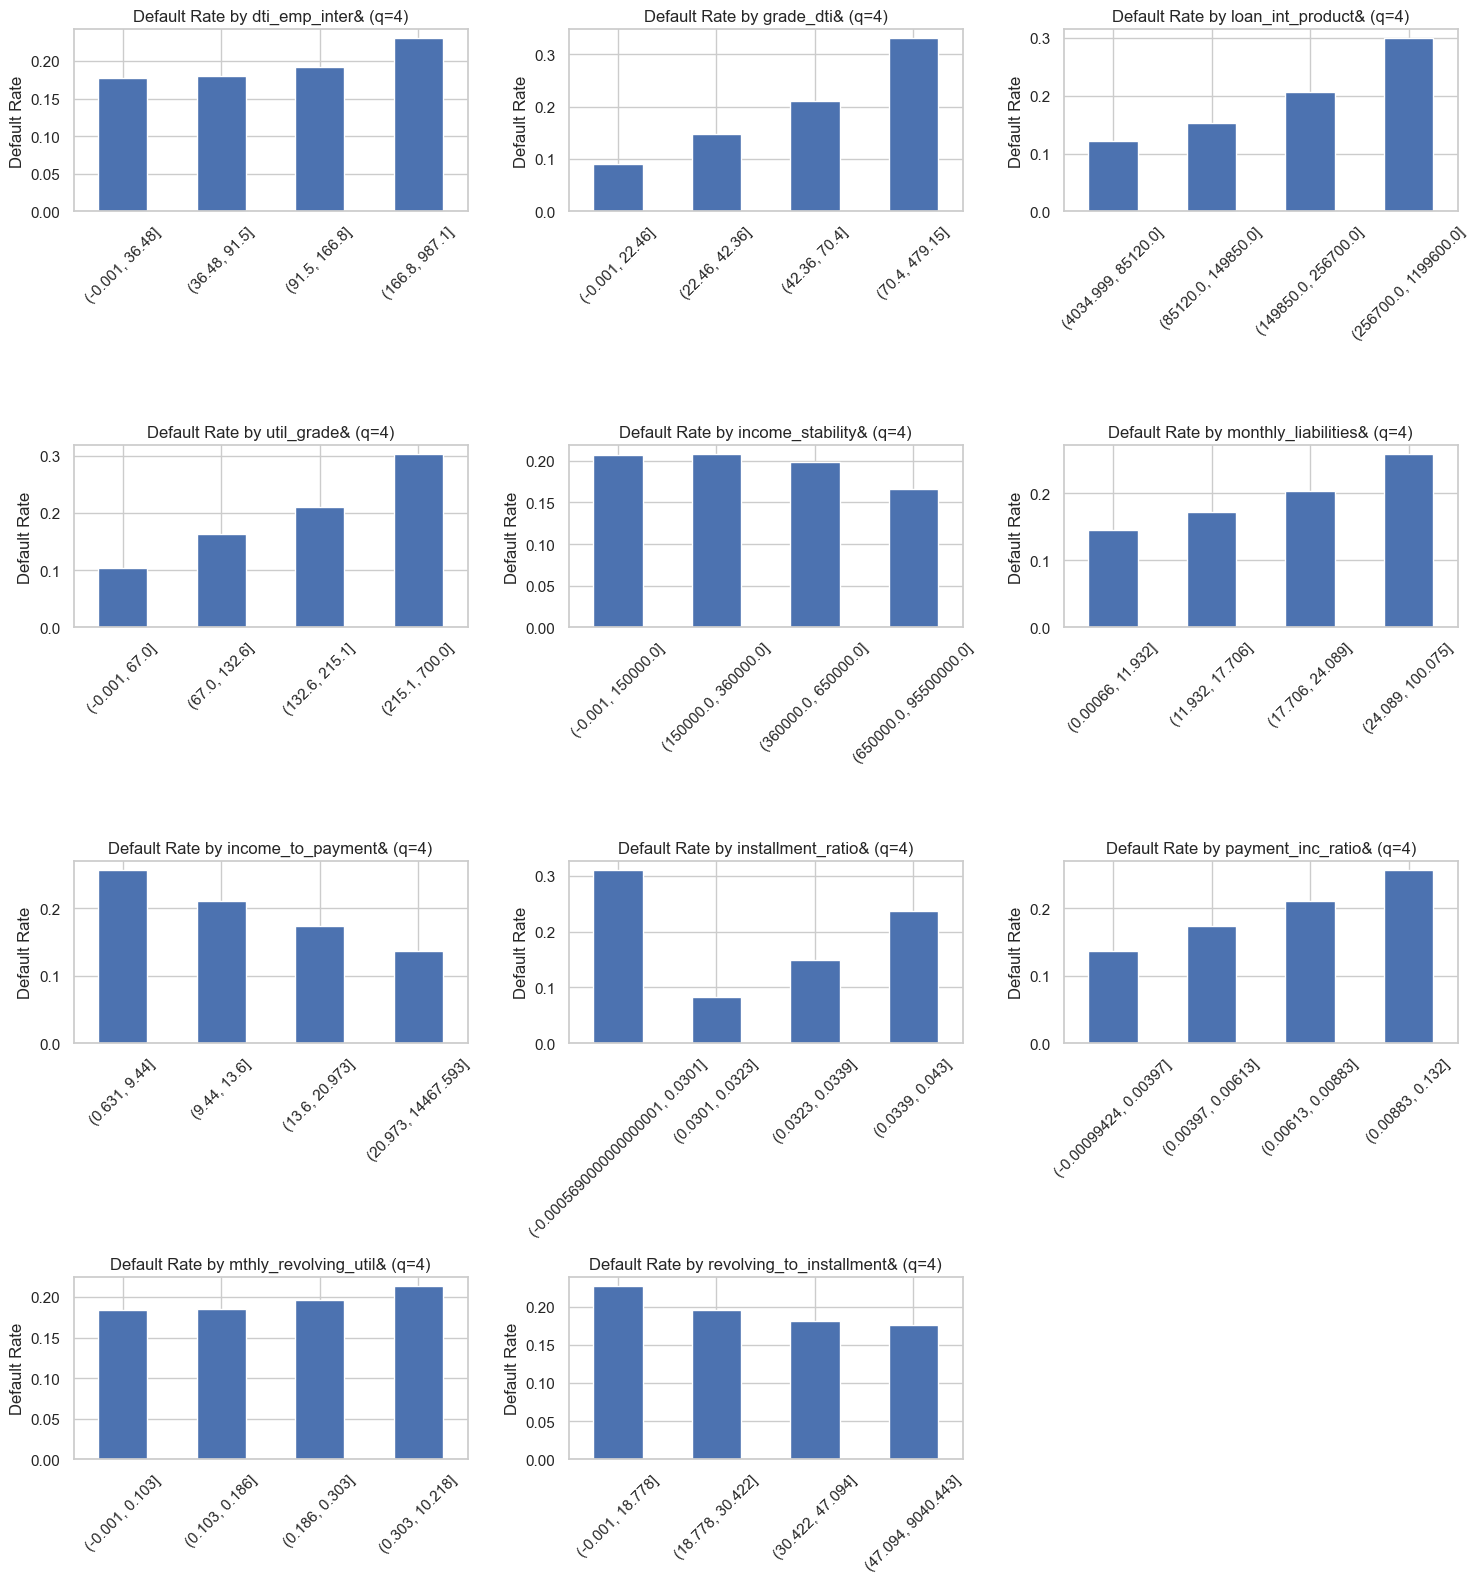

In [30]:
# -------------------------------------------------
# Check Interaction Feature (Trend Checking)
# -------------------------------------------------
plot_default_rate_bars(
    train_pdf_copy_feat_en, new_feats, target="default_status", q=4, ncols=3
)

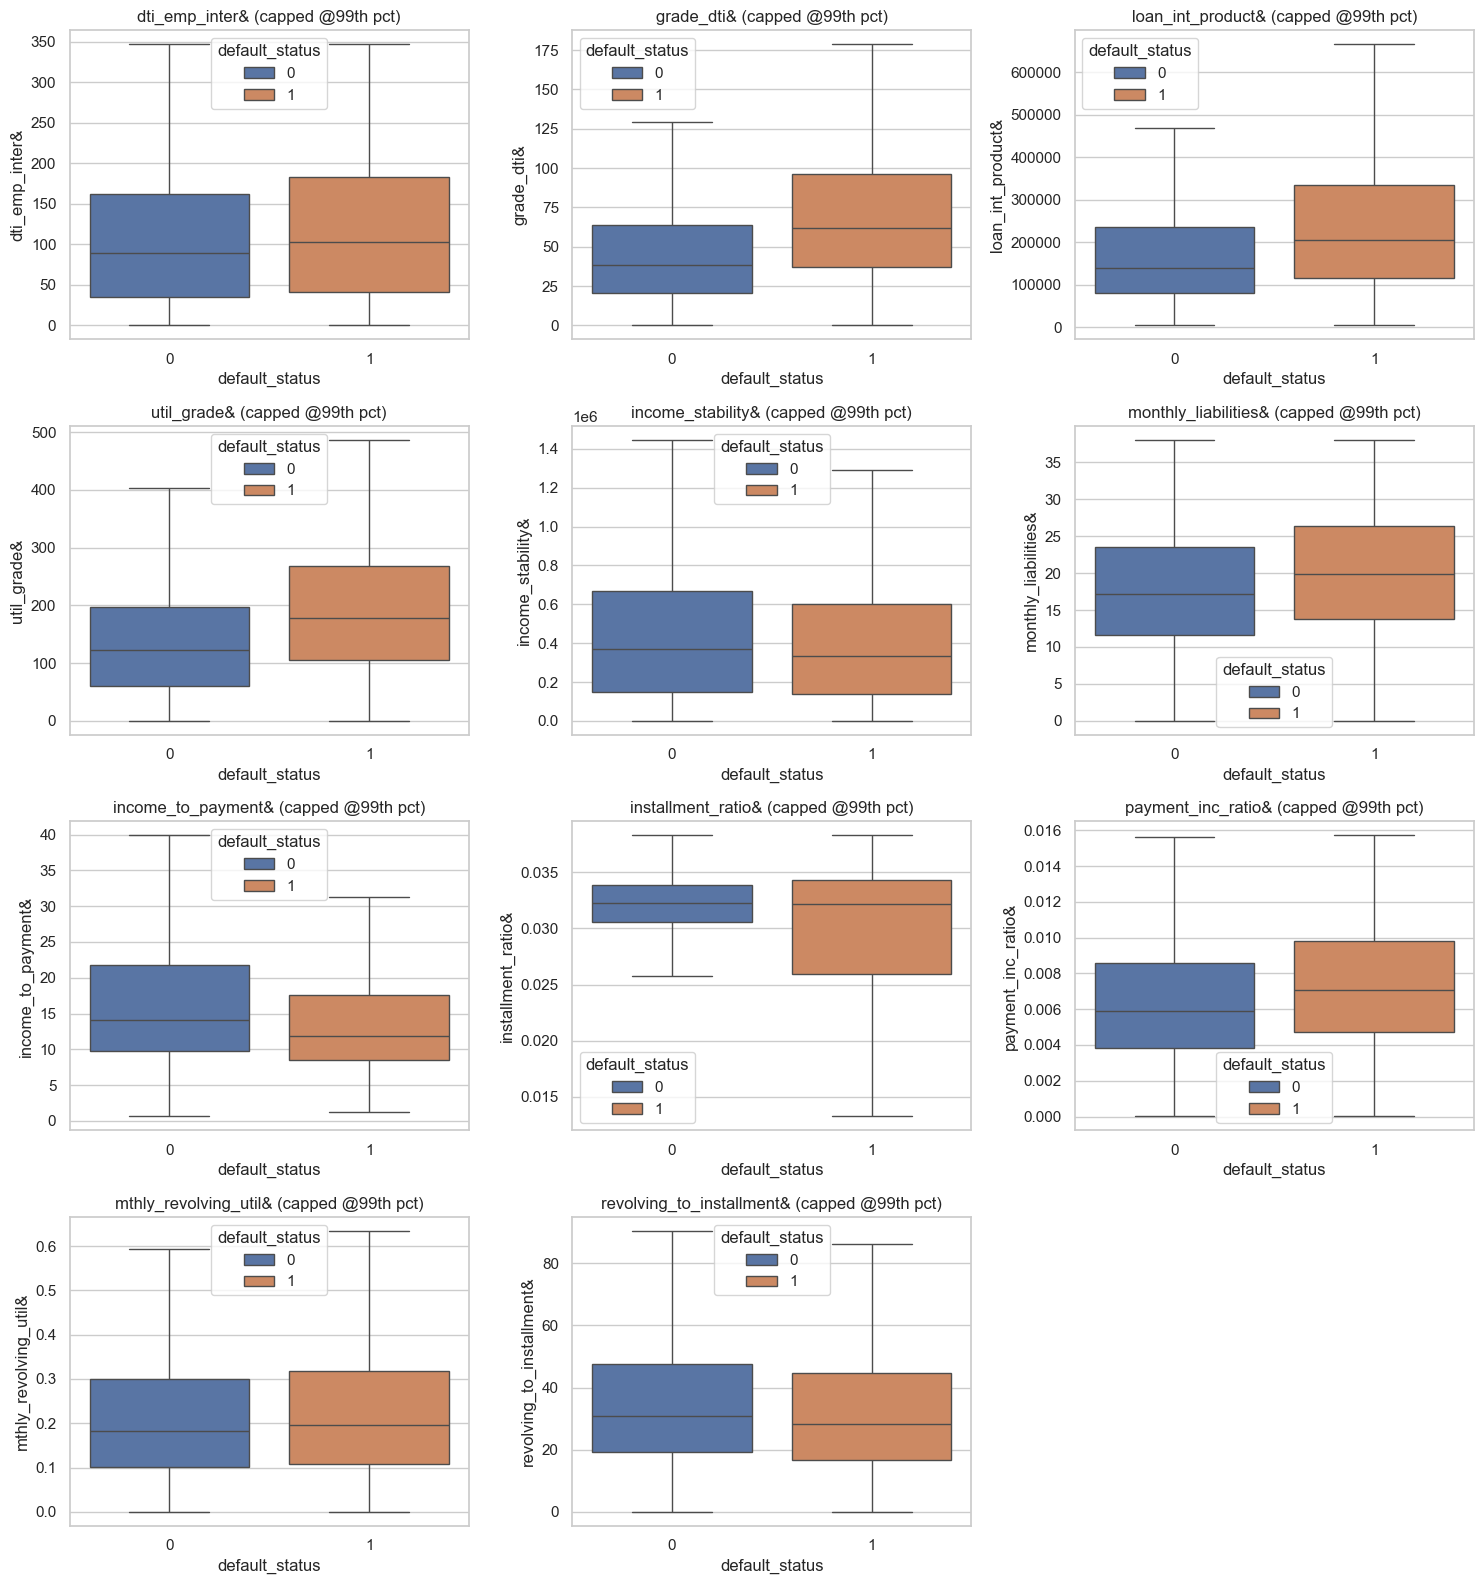

In [31]:
# -------------------------------------------------
# Check Interaction Feature Seperability of Classes
# -------------------------------------------------

plot_boxplots(
    train_pdf_copy_feat_en, new_feats, target="default_status", cap_pct=0.99, ncols=3
)

We can observe the newly created interaction features trend with the mean default rate (whether it is non-monotonic / monotonic). Either way, XGBoost captures them well. However, the boxplots are important, they portray the separaibility of classes by each interaction feature. We want interaction features that have high separability between defaulted / non-defaulted loans. We shall filter final useful interaction features in the list below.


In [32]:
final_interaction_features = [
    "grade_dti&",
    "loan_int_product&",
    "util_grade&",
    "monthly_liabilities&",
    "income_to_payment&",
    "installment_inc_ratio&",
]

In [33]:
class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # simple products (no division)
        X["grade_x_dti"] = X["grade_ord"] * X["dti"]
        X["loan_x_int"] = X["loan_amnt"] * X["int_rate"]
        X["util_x_grade"] = X["revol_util"].fillna(0) * X["grade_ord"]

        # ratios with safe division
        monthly_inc = X["annual_inc"] / 12.0

        X["monthly_liabilities&"] = sdiv(
            X["dti"] * monthly_inc + X["installment"], monthly_inc
        )
        X["income_to_payment"] = sdiv(monthly_inc, X["installment"])
        X["installment_inc_ratio"] = sdiv(X["installment"], X["annual_inc"])

        return X


print(f"Original Shape: {train_pdf_copy.shape}")
interaction_feat_creator = InteractionFeatureCreator()
train_pdf_copy_feat_en = interaction_feat_creator.fit_transform(train_pdf_copy_feat_en)
print(f"Final Shape: {train_pdf_copy.shape}")


train_pdf_copy_feat_en.head()

Original Shape: (1071254, 63)
Final Shape: (1071254, 63)


,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,dti_emp_inter&,grade_dti&,loan_int_product&,util_grade&,income_stability&,monthly_liabilities&,income_to_payment&,installment_ratio&,payment_inc_ratio&,mthly_revolving_util&,revolving_to_installment&,grade_x_dti,loan_x_int,util_x_grade,income_to_payment,installment_inc_ratio
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0,0.00,71.45,103125.0,257.5,0.0,14.429325,7.177439,0.034057,0.011610,0.189773,16.344987,71.45,103125.0,257.5,7.177439,0.011610
1,76597,5000.0,9.01,159.03,250000.0,2007-07-01,0,10.00,2,0,5,0,14354.0,36.6,7,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0,True,False,False,False,True,False,False,True,False,True,False,2,1,10.00,20.00,45050.0,73.2,250000.0,10.007633,131.002536,0.031806,0.000636,0.057416,90.259699,20.00,45050.0,73.2,131.002536,0.000636
2,106360,2700.0,15.96,94.88,52200.0,2007-07-01,0,12.57,0,1,12,0,3075.0,92.3,13,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,627.0,False,False,False,True,True,False,False,True,False,True,False,6,1,12.57,75.42,43092.0,553.8,52200.0,12.591811,45.847386,0.035141,0.001818,0.058908,32.409359,75.42,43092.0,553.8,45.847386,0.001818
3,90665,8500.0,10.28,275.38,18000.0,2007-07-01,0,6.40,1,1,6,0,8847.0,26.9,9,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,20,692.0,False,False,False,True,True,False,False,True,False,True,False,3,3,19.20,19.20,87380.0,80.7,54000.0,6.583587,5.447019,0.032398,0.015299,0.491500,32.126516,19.20,87380.0,80.7,5.447019,0.015299
4,90966,5000.0,7.43,155.38,150000.0,2007-07-01,0,0.00,0,0,2,0,6053.0,19.5,19,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,19,777.0,True,False,False,False,True,False,False,True,False,True,False,1,8,0.00,0.00,37150.0,19.5,1200000.0,0.012430,80.447934,0.031076,0.001036,0.040353,38.956108,0.00,37150.0,19.5,80.447934,0.001036


# 3. XGBoost Model Training

deal with class imbalance with xgboost parameter , pipeline object


In [34]:
# -----------------------------------------------
# Define Pipeline to Transform Train & Test Data
# -----------------------------------------------
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline(
    steps=[
        ("invalid_values_rm", invalid_values_handler),
        ("zero_var_rm", dropper),
        ("one_hot", one_hot_encoder),
        ("ordinal_encoder", grade_emp_length_encoder),
        ("interaction_features_creator", interaction_feat_creator),
    ]
)

In [35]:
# -----------------------------------------------
# Transform Train & Test Data & Validation, using Pipeline
# -----------------------------------------------

# == Train-Test Split (in case) ==
train_pdf, test_pdf = train_test_split_oot(pdf)

# == Train - Validation Split ==
train_pdf, val_pdf = train_test_split_oot(train_pdf)

# == Train Data should learn from Pipeline Object ==
full_pipeline.fit(train_pdf)
train_pdf_final = full_pipeline.transform(train_pdf)
val_pdf_final = full_pipeline.transform(val_pdf)
test_pdf_final = full_pipeline.transform(test_pdf)

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
687631,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
687652,76597,5000.0,36,9.01,159.03,B,1,MORTGAGE,250000.0,Not Verified,2007-07-01,0,10.00,2,0,5,0,14354.0,36.6,7,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0
687661,106360,2700.0,36,15.96,94.88,F,1,RENT,52200.0,Not Verified,2007-07-01,0,12.57,0,1,12,0,3075.0,92.3,13,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,627.0
687660,90665,8500.0,36,10.28,275.38,C,3,RENT,18000.0,Not Verified,2007-07-01,0,6.40,1,1,6,0,8847.0,26.9,9,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,20,692.0
687659,90966,5000.0,36,7.43,155.38,A,8,MORTGAGE,150000.0,Not Verified,2007-07-01,0,0.00,0,0,2,0,6053.0,19.5,19,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,19,777.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
375298,90239923,9600.0,36,13.49,325.74,C,0,RENT,30000.0,Source Verified,2016-10-01,1,31.68,0,0,12,0,3965.0,37.4,16,w,0,Individual,0,42248.0,10600.0,9.0,3521.0,414.0,82.0,0.0,0.0,101.0,34.0,1.0,1.0,0.0,7.0,2.0,0.0,2.0,4.0,2.0,2.0,6.0,9.0,9.0,4.0,12.0,0.0,0.0,0.0,6.0,100.0,50.0,0.0,0.0,55622.0,42248.0,2300.0,45022.0,10,702.0
375297,90936366,12500.0,36,12.79,419.92,C,10,RENT,46000.0,Verified,2016-10-01,1,15.37,0,0,9,1,11432.0,69.3,23,w,0,Individual,0,14491.0,16500.0,6.0,1610.0,1168.0,90.7,0.0,0.0,113.0,131.0,8.0,8.0,0.0,8.0,8.0,0.0,4.0,4.0,4.0,6.0,14.0,6.0,9.0,4.0,9.0,0.0,0.0,0.0,3.0,100.0,100.0,1.0,0.0,21610.0,14491.0,12600.0,5110.0,10,672.0
375296,91197158,20000.0,60,8.59,411.20,A,3,MORTGAGE,191000.0,Not Verified,2016-10-01,0,15.33,0,0,11,0,28679.0,42.3,28,w,0,Individual,0,349645.0,67800.0,6.0,31786.0,33970.0,38.0,0.0,0.0,136.0,188.0,10.0,10.0,4.0,10.0,5.0,0.0,3.0,4.0,5.0,7.0,10.0,7.0,13.0,4.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,462051.0,67730.0,54800.0,67754.0,21,752.0
375295,90264888,5050.0,36,10.99,165.31,B,3,MORTGAGE,103000.0,Not Verified,2016-10-01,0,15.11,0,0,21,0,10159.0,55.2,35,w,0,Individual,0,251864.0,18400.0,4.0,11994.0,6053.0,60.2,0.0,0.0,147.0,111.0,2.0,2.0,2.0,2.0,15.0,0.0,3.0,4.0,3.0,3.0,27.0,5.0,6.0,4.0,21.0,0.0,0.0,0.0,1.0,91.4,66.7,0.0,0.0,250141.0,113154.0,15200.0,89368.0,12,692.0
375294,90156458,11200.0,60,22.74,314.07,E,0,RENT,36000.0,Source Verified,2016-10-01,1,17.80,0,1,17,0,3517.0,52.5,19,w,0,Individual,0,69901.0,6700.0,5.0,4112.0,258.0,82.8,0.0,0.0,62.0,45.0,4.0,4.0,0.0,17.0,0.0,0.0,2.0,4.0,2.0,2.0,13.0,5.0,6.0,4.0,17.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,77642.0,69901.0,1500.0,70942.0,5,697.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
687631,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
687639,112245,5000.0,36,7.43,155.38,A,6,RENT,40000.0,Not Verified,2007-07-01,0,2.55,0,2,4,0,2562.0,14.0,7,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,22,772.0
687643,112323,3500.0,36,10.28,113.39,C,0,RENT,20000.0,Not Verified,2007-07-01,0,1.50,0,0,17,0,1882.0,32.4,18,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,682.0
687642,92507,5000.0,36,7.43,155.38,A,1,OWN,85000.0,Not Verified,2007-07-01,0,0.31,0,0,7,0,216.0,0.6,19,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,9,787.0
687641,94838,3000.0,36,10.28,97.20,C,2,MORTGAGE,200000.0,Not Verified,2007-07-01,0,0.00,1,0,5,0,0.0,0.0,8,f,0,Individual,0,78937.0,24000.0,4.0,7217.0,4662.0,62.7,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,10,677.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
173531,70987259,24000.0,60,11.47,527.47,B,10,MORTGAGE,62730.0,Source Verified,2016-02-01,0,16.47,0,0,7,0,22719.0,83.5,12,w,0,Individual,0,359824.0,27200.0,0.0,59971.0,4481.0,83.5,0.0,0.0,148.0,169.0,87.0,50.0,3.0,87.0,5.0,1.0,4.0,4.0,5.0,6.0,3.0,5.0,6.0,4.0,7.0,0.0,0.0,0.0,0.0,90.9,75.0,0.0,0.0,398846.0,30592.0,27200.0,19646.0,14,682.0
173532,70837647,11825.0,36,18.25,428.99,D,10,MORTGAGE,47000.0,Not Verified,2016-02-01,0,1.76,0,4,12,2,1731.0,16.6,27,w,0,Individual,0,1731.0,10400.0,8.0,173.0,6069.0,22.2,0.0,0.0,88.0,161.0,2.0,2.0,0.0,2.0,3.0,1.0,4.0,4.0,5.0,9.0,11.0,12.0,16.0,4.0,10.0,0.0,0.0,0.0,6.0,88.9,0.0,2.0,0.0,10400.0,1731.0,7800.0,0.0,13,662.0
173533,71065809,5275.0,36,10.75,172.08,B,4,MORTGAGE,36687.0,Verified,2016-02-01,0,22.05,0,1,8,0,778.0,10.7,13,w,0,Individual,0,220357.0,7300.0,1.0,31480.0,5651.0,11.7,0.0,0.0,29.0,93.0,52.0,21.0,3.0,57.0,0.0,0.0,3.0,4.0,3.0,4.0,2.0,5.0,8.0,4.0,8.0,0.0,0.0,0.0,0.0,84.6,0.0,0.0,0.0,252290.0,30400.0,6400.0,38795.0,7,727.0
173534,70711952,10000.0,36,10.75,326.21,B,5,MORTGAGE,95000.0,Source Verified,2016-02-01,0,15.52,0,2,8,0,7672.0,47.4,15,w,0,Individual,0,188452.0,16200.0,6.0,23557.0,6644.0,46.8,0.0,0.0,93.0,400.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,4.0,3.0,6.0,5.0,5.0,8.0,4.0,8.0,0.0,0.0,0.0,5.0,80.0,33.3,0.0,0.0,210094.0,38706.0,12500.0,39234.0,33,687.0
173535,72593606,4500.0,36,8.39,141.83,B,10,MORTGAGE,79000.0,Not Verified,2016-02-01,0,3.34,0,0,9,2,5269.0,21.3,26,w,0,Individual,0,351664.0,24700.0,3.0,43958.0,4869.0,45.9,0.0,0.0,129.0,285.0,13.0,13.0,4.0,20.0,12.0,5.0,2.0,4.0,2.0,7.0,0.0,8.0,22.0,4.0,9.0,0.0,0.0,0.0,0.0,80.8,0.0,0.0,0.0,418658.0,5269.0,9000.0,0.0,23,667.0


In [36]:
from IPython.display import display

display(train_pdf_final.head())
display(val_pdf_final.head())
display(test_pdf_final.head())

,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,grade_x_dti,loan_x_int,util_x_grade,monthly_liabilities&,income_to_payment,installment_inc_ratio
0,87023,7500.0,13.75,255.43,22000.0,2007-06-01,0,14.29,1,0,7,0,4175.0,51.5,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0,False,False,True,False,True,False,False,True,False,True,False,5,0,71.45,103125.0,257.5,14.429325,7.177439,0.011610
1,112245,5000.0,7.43,155.38,40000.0,2007-07-01,0,2.55,0,2,4,0,2562.0,14.0,7,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,22,772.0,False,False,False,True,True,False,False,True,False,True,False,1,6,2.55,37150.0,14.0,2.596614,21.452782,0.003884
2,112323,3500.0,10.28,113.39,20000.0,2007-07-01,0,1.50,0,0,17,0,1882.0,32.4,18,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,682.0,False,False,False,True,True,False,False,True,False,True,False,3,0,4.50,35980.0,97.2,1.568034,14.698533,0.005670
3,92507,5000.0,7.43,155.38,85000.0,2007-07-01,0,0.31,0,0,7,0,216.0,0.6,19,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,9,787.0,False,False,True,False,True,False,False,True,False,True,False,1,1,0.31,37150.0,0.6,0.331936,45.587163,0.001828
4,94838,3000.0,10.28,97.20,200000.0,2007-07-01,0,0.00,1,0,5,0,0.0,0.0,8,78937.0,24000.0,4.0,7217.0,4662.0,62.7,129.0,164.0,8.0,5.0,1.0,13.0,5.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,2.0,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,10,677.0,True,False,False,False,True,False,False,True,False,True,False,3,2,0.00,30840.0,0.0,0.005832,171.467764,0.000486


,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,grade_x_dti,loan_x_int,util_x_grade,monthly_liabilities&,income_to_payment,installment_inc_ratio
0,70987259,24000.0,11.47,527.47,62730.0,2016-02-01,0,16.47,0,0,7,0,22719.0,83.5,12,359824.0,27200.0,0.0,59971.0,4481.0,83.5,148.0,169.0,87.0,50.0,3.0,87.0,5.0,1.0,4.0,4.0,5.0,6.0,3.0,5.0,6.0,4.0,7.0,0.0,0.0,90.9,75.0,0.0,0.0,398846.0,30592.0,27200.0,19646.0,14,682.0,True,False,False,False,False,True,False,False,True,False,True,2,10,32.94,275280.00,167.0,16.570903,9.910516,0.008409
1,70837647,11825.0,18.25,428.99,47000.0,2016-02-01,0,1.76,0,4,12,2,1731.0,16.6,27,1731.0,10400.0,8.0,173.0,6069.0,22.2,88.0,161.0,2.0,2.0,0.0,2.0,3.0,1.0,4.0,4.0,5.0,9.0,11.0,12.0,16.0,4.0,10.0,0.0,6.0,88.9,0.0,2.0,0.0,10400.0,1731.0,7800.0,0.0,13,662.0,True,False,False,False,True,False,False,False,True,True,False,4,10,7.04,215806.25,66.4,1.869529,9.129972,0.009127
2,71065809,5275.0,10.75,172.08,36687.0,2016-02-01,0,22.05,0,1,8,0,778.0,10.7,13,220357.0,7300.0,1.0,31480.0,5651.0,11.7,29.0,93.0,52.0,21.0,3.0,57.0,0.0,0.0,3.0,4.0,3.0,4.0,2.0,5.0,8.0,4.0,8.0,0.0,0.0,84.6,0.0,0.0,0.0,252290.0,30400.0,6400.0,38795.0,7,727.0,True,False,False,False,False,False,True,False,True,True,False,2,4,44.10,56706.25,21.4,22.106286,17.766446,0.004690
3,70711952,10000.0,10.75,326.21,95000.0,2016-02-01,0,15.52,0,2,8,0,7672.0,47.4,15,188452.0,16200.0,6.0,23557.0,6644.0,46.8,93.0,400.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,4.0,3.0,6.0,5.0,5.0,8.0,4.0,8.0,0.0,5.0,80.0,33.3,0.0,0.0,210094.0,38706.0,12500.0,39234.0,33,687.0,True,False,False,False,False,True,False,False,True,True,False,2,5,31.04,107500.00,94.8,15.561205,24.268620,0.003434
4,72593606,4500.0,8.39,141.83,79000.0,2016-02-01,0,3.34,0,0,9,2,5269.0,21.3,26,351664.0,24700.0,3.0,43958.0,4869.0,45.9,129.0,285.0,13.0,13.0,4.0,20.0,12.0,5.0,2.0,4.0,2.0,7.0,0.0,8.0,22.0,4.0,9.0,0.0,0.0,80.8,0.0,0.0,0.0,418658.0,5269.0,9000.0,0.0,23,667.0,True,False,False,False,True,False,False,False,True,True,False,2,10,6.68,37755.00,42.6,3.361544,46.417072,0.001795


,id,loan_amnt,int_rate,installment,annual_inc,issue_d,default_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,term_36,term_60,grade_ord,emp_length_ord,grade_x_dti,loan_x_int,util_x_grade,monthly_liabilities&,income_to_payment,installment_inc_ratio
0,90239923,9600.0,13.49,325.74,30000.0,2016-10-01,1,31.68,0,0,12,0,3965.0,37.4,16,42248.0,10600.0,9.0,3521.0,414.0,82.0,101.0,34.0,1.0,1.0,0.0,7.0,2.0,0.0,2.0,4.0,2.0,2.0,6.0,9.0,9.0,4.0,12.0,0.0,6.0,100.0,50.0,0.0,0.0,55622.0,42248.0,2300.0,45022.0,10,702.0,False,False,False,True,False,True,False,False,True,True,False,3,0,95.04,129504.0,112.2,31.810296,7.674833,0.010858
1,90936366,12500.0,12.79,419.92,46000.0,2016-10-01,1,15.37,0,0,9,1,11432.0,69.3,23,14491.0,16500.0,6.0,1610.0,1168.0,90.7,113.0,131.0,8.0,8.0,0.0,8.0,8.0,0.0,4.0,4.0,4.0,6.0,14.0,6.0,9.0,4.0,9.0,0.0,3.0,100.0,100.0,1.0,0.0,21610.0,14491.0,12600.0,5110.0,10,672.0,False,False,False,True,False,False,True,False,True,True,False,3,10,46.11,159875.0,207.9,15.479544,9.128723,0.009129
2,91197158,20000.0,8.59,411.20,191000.0,2016-10-01,0,15.33,0,0,11,0,28679.0,42.3,28,349645.0,67800.0,6.0,31786.0,33970.0,38.0,136.0,188.0,10.0,10.0,4.0,10.0,5.0,0.0,3.0,4.0,5.0,7.0,10.0,7.0,13.0,4.0,11.0,0.0,2.0,100.0,0.0,0.0,0.0,462051.0,67730.0,54800.0,67754.0,21,752.0,True,False,False,False,True,False,False,False,True,False,True,1,3,15.33,171800.0,42.3,15.355835,38.707847,0.002153
3,90264888,5050.0,10.99,165.31,103000.0,2016-10-01,0,15.11,0,0,21,0,10159.0,55.2,35,251864.0,18400.0,4.0,11994.0,6053.0,60.2,147.0,111.0,2.0,2.0,2.0,2.0,15.0,0.0,3.0,4.0,3.0,3.0,27.0,5.0,6.0,4.0,21.0,0.0,1.0,91.4,66.7,0.0,0.0,250141.0,113154.0,15200.0,89368.0,12,692.0,True,False,False,False,True,False,False,False,True,True,False,2,3,30.22,55499.5,110.4,15.129259,51.922650,0.001605
4,90156458,11200.0,22.74,314.07,36000.0,2016-10-01,1,17.80,0,1,17,0,3517.0,52.5,19,69901.0,6700.0,5.0,4112.0,258.0,82.8,62.0,45.0,4.0,4.0,0.0,17.0,0.0,0.0,2.0,4.0,2.0,2.0,13.0,5.0,6.0,4.0,17.0,0.0,1.0,100.0,100.0,0.0,0.0,77642.0,69901.0,1500.0,70942.0,5,697.0,False,False,False,True,False,True,False,False,True,False,True,5,0,89.00,254688.0,262.5,17.904690,9.552011,0.008724


In [37]:
X_train_pdf_final = train_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_train_final = train_pdf_final["default_status"]

X_val_final = val_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_val_final = val_pdf_final["default_status"]

The following is an explanation of the parameters of the XGBoost Model.

- `objective='binary:logistic'`: We are solving the problem of binary classification.

- `early_stopping_rounds=20`: After 20 rounds, if the AUC_PR score does not improve, the model will stop.

- `eval_metric='aucpr'`: 'AUCPR' means the area under the precision-recall curve. We are more focused on whether the predicted list of risky borrowers is actually useful (i.e. evaluating precision and recall), compared to the common metric 'auc', which only cares if our model ranks risky borrowers high above lower-risk borrowers (which may be inflated, when many of the model's predicted borrowers are false alarms).

- `eval_set=[(x_train, y_train), (x_test, y_test)]`: Generate the data for performance learning curves drawn later to compare how good the model performs on training and test set.


In [38]:
# -------------------
# XGBoost Model
# -------------------

counts = train_pdf_final["default_status"].value_counts()
scale_pos_weight_val = counts[0] / counts[1]


xgb_1st = xgb.XGBClassifier(
    objective="binary:logistic",  # binary classification problem
    eval_metric="aucpr",  # better metric than auc (esp for class imbalance)
    random_state=42,  # constant results
    use_label_encoder=False,  # remove warnings in recent XGBoost versions
    scale_pos_weight=scale_pos_weight_val,  # for class imbalance
    n_estimators=100,  # default number of trees
    max_depth=5,  # default tree depth/height
    learning_rate=0.1,
    early_stopping_rounds=20,  # stop if no improvement after 20 rounds
)

In [39]:
# ----------------------
# XGBoost Model Training
# ----------------------

# == Evaluate Model Performance on Validation. Performance on test dataset is AFTER HYPERPARAMETER TUNING ==

xgb_1st.fit(
    X_train_pdf_final,
    y_train_final,
    eval_set=[(X_train_pdf_final, y_train_final), (X_val_final, y_val_final)],
    verbose=1,  # print messages during training
)

[0]	validation_0-aucpr:0.34895	validation_1-aucpr:0.40096
[1]	validation_0-aucpr:0.35313	validation_1-aucpr:0.40291


/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [11:24:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[2]	validation_0-aucpr:0.35478	validation_1-aucpr:0.40444
[3]	validation_0-aucpr:0.35692	validation_1-aucpr:0.40648
[4]	validation_0-aucpr:0.35868	validation_1-aucpr:0.40732
[5]	validation_0-aucpr:0.35930	validation_1-aucpr:0.40799
[6]	validation_0-aucpr:0.36086	validation_1-aucpr:0.41001
[7]	validation_0-aucpr:0.36151	validation_1-aucpr:0.41055
[8]	validation_0-aucpr:0.36255	validation_1-aucpr:0.41184
[9]	validation_0-aucpr:0.36329	validation_1-aucpr:0.41330
[10]	validation_0-aucpr:0.36390	validation_1-aucpr:0.41396
[11]	validation_0-aucpr:0.36504	validation_1-aucpr:0.41506
[12]	validation_0-aucpr:0.36559	validation_1-aucpr:0.41545
[13]	validation_0-aucpr:0.36627	validation_1-aucpr:0.41609
[14]	validation_0-aucpr:0.36685	validation_1-aucpr:0.41661
[15]	validation_0-aucpr:0.36744	validation_1-aucpr:0.41737
[16]	validation_0-aucpr:0.36798	validation_1-aucpr:0.41806
[17]	validation_0-aucpr:0.36869	validation_1-aucpr:0.41866
[18]	validation_0-aucpr:0.36926	validation_1-aucpr:0.41907
[19]	

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'aucpr'


# 4. Model Evaluation

Now, we will be checking the Accuracy, Precision, Recall, F1 Score, Gini for both default and non-default loans. We will be plotting confusion matrices to inspect false positives, false negatives, true positives and true negatives as well.

Plotting the learning curves helps to check or diagnose the problem of the training model (such as underfiting, overfiting in training/test set)


### 4.1 Evaluation on Train, Validation Data


In [40]:
# --------------------------
# Model Evaluation Functions
# --------------------------
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


def evaluate_model(model, data_x, data_y):
    y_pred = model.predict(data_x)
    print("\n1) CLASSIFICATION REPORT:")
    print(classification_report(data_y, y_pred))
    print("\n2) CONFUSION MATRIX")

    # This replaces plot_confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        data_x,
        data_y,
        display_labels=["Non-Default", "Default"],
        cmap=plt.cm.Blues,
        normalize=None,  # or 'true', 'pred', 'all'
    )
    disp.ax_.set_title("Confusion Matrix")
    plt.show()


1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76    699053
           1       0.31      0.68      0.43    157989

    accuracy                           0.66    857042
   macro avg       0.61      0.67      0.59    857042
weighted avg       0.79      0.66      0.70    857042


2) CONFUSION MATRIX


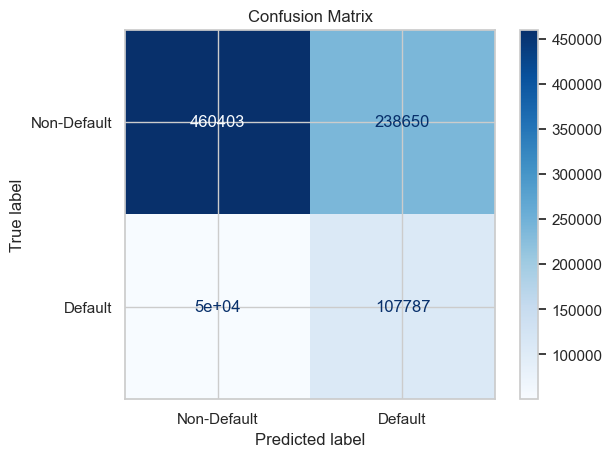

In [41]:
# ------------------------------
# Model Evaluation on Train Data
# ------------------------------

evaluate_model(xgb_1st, X_train_pdf_final, y_train_final)


1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75    163454
           1       0.37      0.65      0.48     50758

    accuracy                           0.66    214212
   macro avg       0.62      0.66      0.61    214212
weighted avg       0.74      0.66      0.68    214212


2) CONFUSION MATRIX


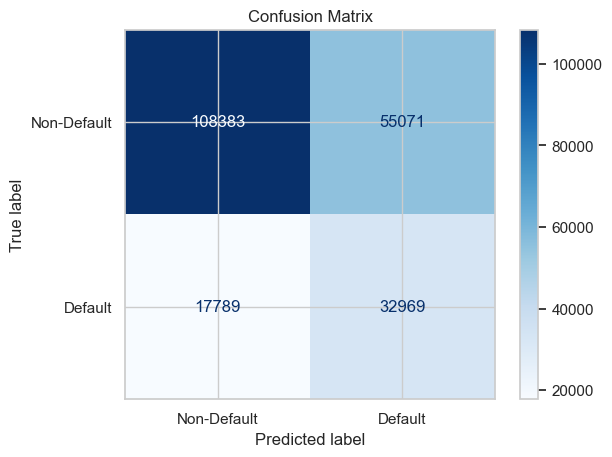

In [42]:
# ------------------------------
# Model Evaluation on Validation Data
# ------------------------------

evaluate_model(xgb_1st, X_val_final, y_val_final)

In [43]:
# -----------------------
# Gini Calculation (Train)
# -----------------------
from sklearn.metrics import roc_auc_score

y_proba_train = xgb_1st.predict_proba(X_train_pdf_final)[:, 1]
auc = roc_auc_score(y_train_final, y_proba_train)
gini = 2 * auc - 1
print(f"AUC: {auc:.4f}, Gini: {gini:.4f}")

AUC: 0.7346, Gini: 0.4691


In [44]:
# -----------------------
# Gini Calculation (Validation)
# -----------------------
from sklearn.metrics import roc_auc_score

y_proba = xgb_1st.predict_proba(X_val_final)[:, 1]
auc = roc_auc_score(y_val_final, y_proba)
gini = 2 * auc - 1
print(f"AUC: {auc:.4f}, Gini: {gini:.4f}")

AUC: 0.7184, Gini: 0.4367


In [45]:
# -----------------------
# Lift over Baseline (Train)
# -----------------------
from sklearn.metrics import average_precision_score

pos_rate = y_train_final.mean()  # mean positive rate
ap = average_precision_score(
    y_train_final, y_proba_train
)  # model's PR-AUC (avg precision across all recalls)

lift = ap / (pos_rate + 1e-12)  # how many × better than baseline

print(f"Baseline positive rate: {pos_rate:.3f}")
print(f"AUC-PR (AP): {ap:.3f}  |  Lift over baseline: {lift:.2f}x")

Baseline positive rate: 0.184
AUC-PR (AP): 0.391  |  Lift over baseline: 2.12x


In [46]:
# -----------------------
# Lift over Baseline (Validation)
# -----------------------
from sklearn.metrics import average_precision_score

pos_rate = y_val_final.mean()  # mean positive rate
ap = average_precision_score(
    y_val_final, y_proba
)  # model's PR-AUC (avg precision across all recalls)

lift = ap / (pos_rate + 1e-12)  # how many × better than baseline

print(f"Baseline positive rate: {pos_rate:.3f}")
print(f"AUC-PR (AP): {ap:.3f}  |  Lift over baseline: {lift:.2f}x")

Baseline positive rate: 0.237
AUC-PR (AP): 0.437  |  Lift over baseline: 1.84x


This means that our baseline XGBoost Model performs 1.8x better than random guessing our test dataset. This means that our model handles class imbalance decently. Now, we shall proceed on to plot our Precision-Recall curve. The purpose of plotting the Precision-Recall curve is to identify good thresholds to distinguish between a defaulted / non-defaulted loan.

For example, the ideal scenario would be to identify a region where both Precision & Recall lies >= 0.6. If I have high recall, but too low a precision, I should then allocate lower class weightage to the default class, so that I would have best of both worlds.


### 4.2 Plot Precision-Recall Curve


Text(0, 0.5, 'Precision')

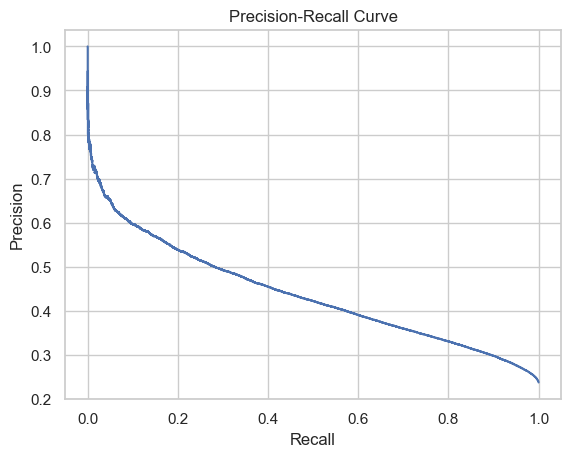

In [47]:
y_pred_1st = xgb_1st.predict_proba(X_val_final)[:, 1]

precision, recall, _ = precision_recall_curve(y_val_final, y_pred_1st)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

Based on the above Precision-Recall Curve, it seems that none of our metrics can be both 0.6 at the same time. This suggests that our model is over-predicting defaults, over non-defaulters. We shall conduct a Cause Analysis for this.

This might be likely because we defined `scale_pos_weight=(#non-defaults)/defaults`. However, this class weighting ratio may not be optimal. For example, given that our ratio is 4.13, our model pays 4.13x more attention to default class than non-default class. Hence, there may be too much attention on default-classes when our XGBoost model is fitted to the data points, resulting in a high recall, in expense of low precision.

### 4.3 Plot Learning Curve

Now we shall be plotting the learning curve of our train & validation datasets. This is a plot which showcases the model metrics (auc-pr score) across training iterations. A good output would be if learning curves of both train & validation datasets both increase, and converge, with no big gaps between them. Bad learning curve, i.e. bad model performance, would be when the validation dataset plateaus early compared to train dataset. When there is such a wide divergence between train and validation learning curves, it means our model fails to capture full patterns and fails to generalize.


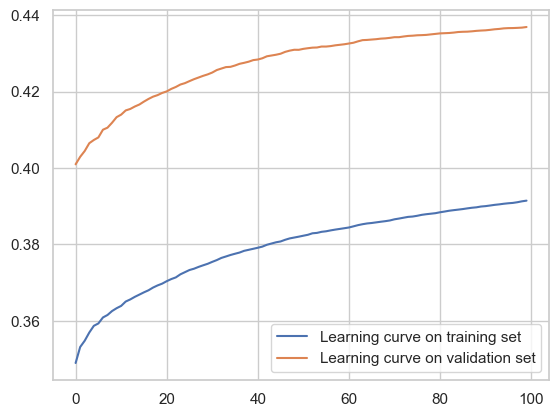

In [48]:
# define a learning curves function
def learn_curves(fitted_model):

    # retrieve performance metrics
    results = fitted_model.evals_result()

    # plot learning curves
    plt.plot(results["validation_0"]["aucpr"], label="Learning curve on training set")
    plt.plot(results["validation_1"]["aucpr"], label="Learning curve on validation set")

    # show the legends and plot
    plt.legend()


learn_curves(xgb_1st)

In [49]:
# ---------------------------------------------------------
# Explain weird phenonmeon of why aucpr > on validation set
# ----------------------------------------------------------

from sklearn.metrics import average_precision_score

# baselines (prevalence)
print("train base:", y_train_final.mean())
print("val   base:", y_val_final.mean())

# AP on both sets using the fitted model
p_train = xgb_1st.predict_proba(X_train_pdf_final)[:, 1]
p_val = xgb_1st.predict_proba(X_val_final)[:, 1]

ap_train = average_precision_score(y_train_final, p_train)
ap_val = average_precision_score(y_val_final, p_val)

print(f"AP train: {ap_train:.3f}  (lift {ap_train/(y_train_final.mean()+1e-12):.2f}x)")
print(f"AP val  : {ap_val:.3f}  (lift {ap_val/(y_val_final.mean()+1e-12):.2f}x)")

train base: 0.1843421909311329
val   base: 0.23695217821597298
AP train: 0.391  (lift 2.12x)
AP val  : 0.437  (lift 1.84x)


As seen from our curve, it is unusual that our validation set performs better in aucpr compared to our train dataset. Upon research, it seems that when the mean default rate in our validation set is higher than our train set, aucpr will naturally be higher, since auc_pr depends largely on positive rate of the dataset, in contrast with auc curve. For example, when data is 10% defaults, a random guess would average ~0.10. When data is 30% default, random sampling will also garner ~ 0.30. As such, datasets with higher positive rates will have naturally higher auc_pr (which is average precision). This can be visualised using the Precision formula easily.

### 4.4 Conclusion

- **Classification Report**: Model is much better in predicting non-defaults than defaults. For example, on Validation Dataset, there were ~55k predicted defaults, when they are actually non-defaults, which creates false alarms, and potential revenue loss
- **Precision-Recall Curve**: Precision is very low at high recall, which means the model struggles to identify default class accurately without sacrificing precision.
- **Learning Curves**: Gap between curves is stable, but overall AUC-PR values for both curves aren't good enough (0.36 - 0.43). Our model isn't learning highly distinctive patterns to differentiate defaults and non-defaults

### 4.5 Diagnosis & Tuning Strategy

- Class Imbalance is affecting model performance (Strategy: Finetune `scale_pos_weight` to make it lower)
- Model has some degree of overfitting (Strategy: Regularize to reduce noise, e.g. reduce `max_depth` etc)
- Tune sampling & learning rate in order to make learning smoother, and increase `early_stopping_rounds` to allow trees to learn at a slower rate, but improve accuracy


# 5. Hyperparameter Tuning


In [50]:
# ------------------------------------
# Time Series Split & Random Searching
# ------------------------------------

# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from sklearn.metrics import make_scorer, average_precision_score


# tscv = TimeSeriesSplit(n_splits=5)


# # 3) allows custom scoring of XGBoost Model (uses aucpr instead of auc), uses predicted probabilities instead of 0 / 1 to get best hyperparameters
# def recall_at_precision_floor(y_true, y_score, pmin=0.40):
#     # y_score: positive-class probabilities (1-D)
#     if (y_true.sum() == 0) or (y_true.sum() == len(y_true)):
#         return 0.0  # degenerate fold
#     prec, rec, thr = precision_recall_curve(y_true, y_score)
#     feas = prec[:-1] >= pmin
#     return float(rec[:-1][feas].max()) if np.any(feas) else 0.0


# def recall_at_pfloor_scorer(estimator, X, y):
#     proba = estimator.predict_proba(X)[:, 1]
#     return recall_at_precision_floor(y, proba, pmin=0.40)


# # Use counts from TRAIN ONLY
# pos = int((y_train_final == 1).sum())
# neg = int((y_train_final == 0).sum())
# scale_pos_weight_guess = max(1.0, neg / max(1, pos))

# param_dist = {
#     # ↓ Simpler trees to cut overfitting; still allow some depth for signal
#     "max_depth": [3, 4, 5, 6],
#     # ↑ Require more samples to split; fewer flimsy leaves → fewer false alarms
#     "min_child_weight": [2, 4, 6, 8],
#     # ↑ Demand more improvement to split; filters noisy splits
#     "gamma": [0.0, 0.2, 0.5, 1.0],
#     # Row/feature sampling <1 adds randomness; helps generalization
#     "subsample": [0.6, 0.75, 0.9],
#     "colsample_bytree": [0.6, 0.75, 0.9],
#     # Smoother learning: smaller steps + more trees
#     "learning_rate": [0.02, 0.03, 0.05, 0.08],
#     "n_estimators": [400, 500, 600, 800, 1000, 1200, 1600, 2000],
#     # Class-imbalance dial: search around the ratio (often best is LOWER than ratio)
#     "scale_pos_weight": [
#         max(1.0, scale_pos_weight_guess * 0.5),
#         max(1.0, scale_pos_weight_guess * 0.75),
#         scale_pos_weight_guess,
#         scale_pos_weight_guess * 1.25,
#     ],
#     # Penalties to reduce overfit (pushes model to be simpler)
#     "reg_alpha": [0.0, 0.1, 0.3, 1.0],  # L1
#     "reg_lambda": [1.0, 3.0, 6.0, 10.0],  # L2
# }


# # 6) Base model
# xgb_tuning = xgb.XGBClassifier(
#     objective="binary:logistic",
#     tree_method="hist",  # fast + stable
#     eval_metric="aucpr",  # monitor PR during fit
#     n_jobs=-1,  # use all CPU Cores
#     random_state=42,
# )

# # 7) Randomized search over TimeSeriesSplit
# search = RandomizedSearchCV(
#     estimator=xgb_tuning,
#     param_distributions=param_dist,
#     n_iter=40,
#     scoring=recall_at_pfloor_scorer,  # PR/AUC (average precision) is what we care about
#     cv=tscv,
#     n_jobs=-1,
#     verbose=1,
#     refit=True,  # refit the best params on the full training span
# )

# # 8) Fit on training data (keep your final OOT window out of X,y if you use one)
# search.fit(X_train_pdf_final, y_train_final)

# print("\nBest Average Precision (CV):", round(search.best_score_, 4))
# print("Best hyperparameters:")
# for k, v in search.best_params_.items():
#     print(f"  {k}: {v}")

In [51]:
# -----------------------------
# Final Tuned Model Performance
# -----------------------------

# == Define X_test & Y_test ==
X_test_final = test_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_test_final = test_pdf_final["default_status"]

best_params = {
    "subsample": 0.75,
    "scale_pos_weight": 5.532697884086967,
    "reg_lambda": 6.0,
    "reg_alpha": 0.0,
    "n_estimators": 1600,
    "min_child_weight": 2,
    "max_depth": 4,
    "learning_rate": 0.03,
    "gamma": 0.5,
    "colsample_bytree": 0.6,
    "random_state": 42,
    "n_jobs": -1,
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "early_stopping_rounds": 50,
}

# best_params = {
#     "subsample": 0.9,
#     "scale_pos_weight": 2.2130791536347867,
#     "reg_lambda": 3.0,
#     "reg_alpha": 1.0,
#     "n_estimators": 1200,
#     "min_child_weight": 4,
#     "max_depth": 5,
#     "learning_rate": 0.02,
#     "gamma": 0.5,
#     "colsample_bytree": 0.9,
#     "random_state": 42,
#     "n_jobs": -1,
#     "objective": "binary:logistic",
#     "eval_metric": "aucpr",
#     "early_stopping_rounds": 50,
# }

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train_pdf_final,
    y_train_final,
    eval_set=[(X_train_pdf_final, y_train_final), (X_test_final, y_test_final)],
)

[0]	validation_0-aucpr:0.31871	validation_1-aucpr:0.33118
[1]	validation_0-aucpr:0.34481	validation_1-aucpr:0.34948
[2]	validation_0-aucpr:0.34993	validation_1-aucpr:0.35503
[3]	validation_0-aucpr:0.35078	validation_1-aucpr:0.35505
[4]	validation_0-aucpr:0.35180	validation_1-aucpr:0.35554
[5]	validation_0-aucpr:0.35253	validation_1-aucpr:0.35489
[6]	validation_0-aucpr:0.35580	validation_1-aucpr:0.35481
[7]	validation_0-aucpr:0.35555	validation_1-aucpr:0.35524
[8]	validation_0-aucpr:0.35569	validation_1-aucpr:0.35551
[9]	validation_0-aucpr:0.35564	validation_1-aucpr:0.35595
[10]	validation_0-aucpr:0.35657	validation_1-aucpr:0.35701
[11]	validation_0-aucpr:0.35650	validation_1-aucpr:0.35727
[12]	validation_0-aucpr:0.35658	validation_1-aucpr:0.35754
[13]	validation_0-aucpr:0.35648	validation_1-aucpr:0.35762
[14]	validation_0-aucpr:0.35675	validation_1-aucpr:0.35879
[15]	validation_0-aucpr:0.35706	validation_1-aucpr:0.35986
[16]	validation_0-aucpr:0.35723	validation_1-aucpr:0.35996
[17]	va

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'aucpr'



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.57      0.69    163454
           1       0.35      0.74      0.48     50758

    accuracy                           0.61    214212
   macro avg       0.61      0.66      0.59    214212
weighted avg       0.75      0.61      0.64    214212


2) CONFUSION MATRIX


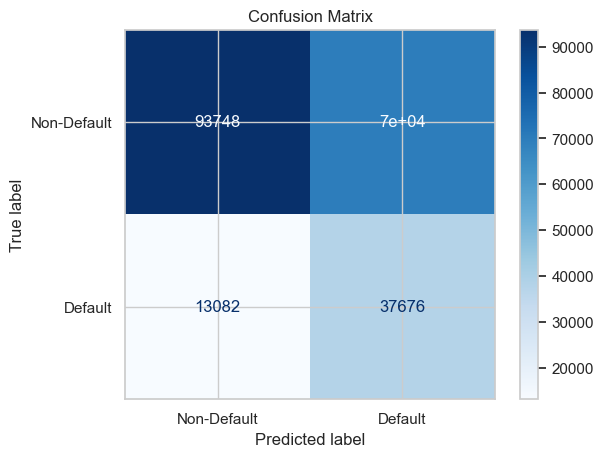

In [52]:
# -----------------------------------------------------------
# After Hyperparameter Tuning (Model Eval on Validation Set)
# -----------------------------------------------------------
evaluate_model(final_model, X_val_final, y_val_final)

Text(0, 0.5, 'Precision')

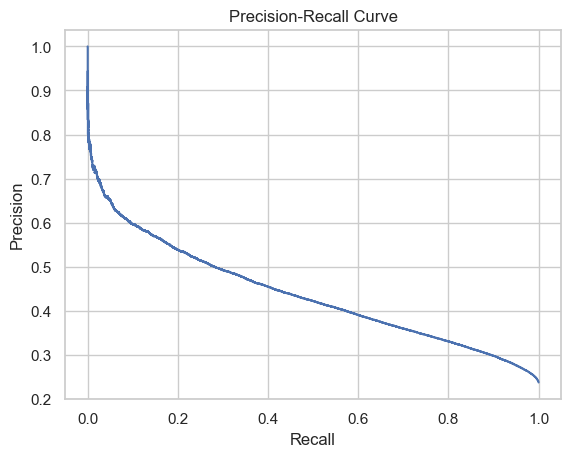

In [53]:
# -----------------------------------------------------------
# Check Precision-Recall Curve (Validation Set )
# -----------------------------------------------------------

probas = final_model.predict_proba(X_val_final)[:, 1]
prec, rec, thr = precision_recall_curve(y_val_final, probas)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

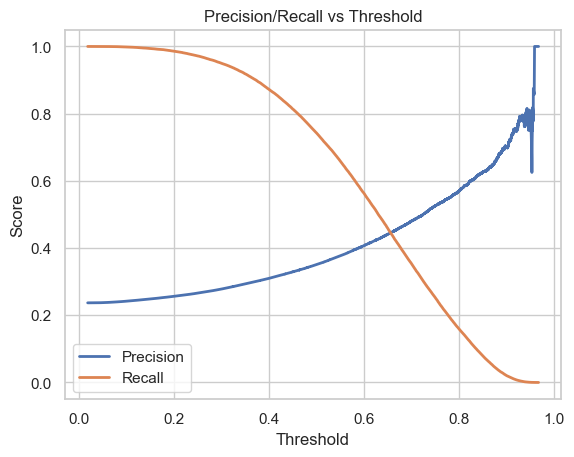

In [54]:
def plot_precision_recall_vs_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)

    # thr aligns with prec[:-1]/rec[:-1]
    t = thr

    fig, ax1 = plt.subplots()
    ax1.plot(t, prec[:-1], linewidth=2, label="Precision")
    ax1.plot(t, rec[:-1], linewidth=2, label="Recall")
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Score")
    ax1.set_title("Precision/Recall vs Threshold")
    ax1.legend(loc="best")
    plt.show()


# ---- usage ----
plot_precision_recall_vs_threshold(y_val_final, probas)

In [55]:
# --- Pick a threshold ---
threshold = 0.522  # adjust this value

# --- Apply threshold ---
y_pred = (probas >= threshold).astype(int)

# --- Evaluate ---
print("Threshold:", threshold)
print("Precision:", precision_score(y_val_final, y_pred))
print("Recall   :", recall_score(y_val_final, y_pred))
print("F1-score :", f1_score(y_val_final, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val_final, y_pred))

Threshold: 0.522
Precision: 0.361927725429269
Recall   : 0.7067851373182552
F1-score : 0.4787163063784361
Confusion matrix:
 [[100207  63247]
 [ 14883  35875]]



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69    209193
           1       0.32      0.74      0.45     58164

    accuracy                           0.60    267357
   macro avg       0.60      0.65      0.57    267357
weighted avg       0.76      0.60      0.64    267357


2) CONFUSION MATRIX


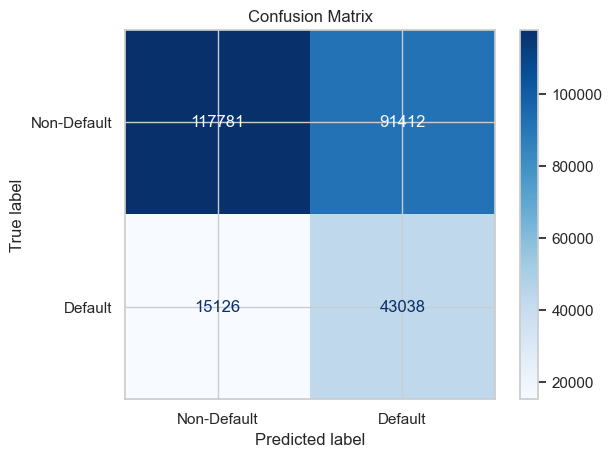

In [56]:
# -----------------------------------------------------------
# After Hyperparameter Tuning (Model Eval on Test Set)
# -----------------------------------------------------------

evaluate_model(final_model, X_test_final, y_test_final)

In [57]:
# ---------------------------
# Wandb Log for Default Class
# ---------------------------
y_pred_prob = final_model.predict_proba(X_test_final)

# For binary classification, extract the probabilities of the positive class (class 1)
y_pred_prob_positive_class = y_pred_prob[:, 1]

# Get predicted class labels based on a threshold (0.5 by default)
y_pred_class = (y_pred_prob_positive_class >= 0.5).astype(int)

# Compute metrics
cm = confusion_matrix(y_test_final, y_pred_class)
f1 = f1_score(y_test_final, y_pred_class)
precision = precision_score(y_test_final, y_pred_class)
recall = recall_score(y_test_final, y_pred_class)
auc = roc_auc_score(y_test_final, y_pred_prob_positive_class)
gini = 2 * auc - 1

wandb.init(
    entity="wlunlun1212-singapore-management-university",
    project="Credit Risk Modeling",
    name="XGBoost Final",  #! change to logistic_regression_base_features b4 rest of the preprocessing steps
    group=NOTEBOOK_RUN_NAME,
)

# Log all metrics in one shot
wandb.log(
    {
        "Model Type": "XGBoost",
        "Gini": gini,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix (sns)": wandb.Image(cm),
    }
)

# Finish wandb logging
wandb.finish()

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
F1 Score,0.44688
Gini,0.42139
Model Type,XGBoost
Precision,0.3201
Recall,0.73994


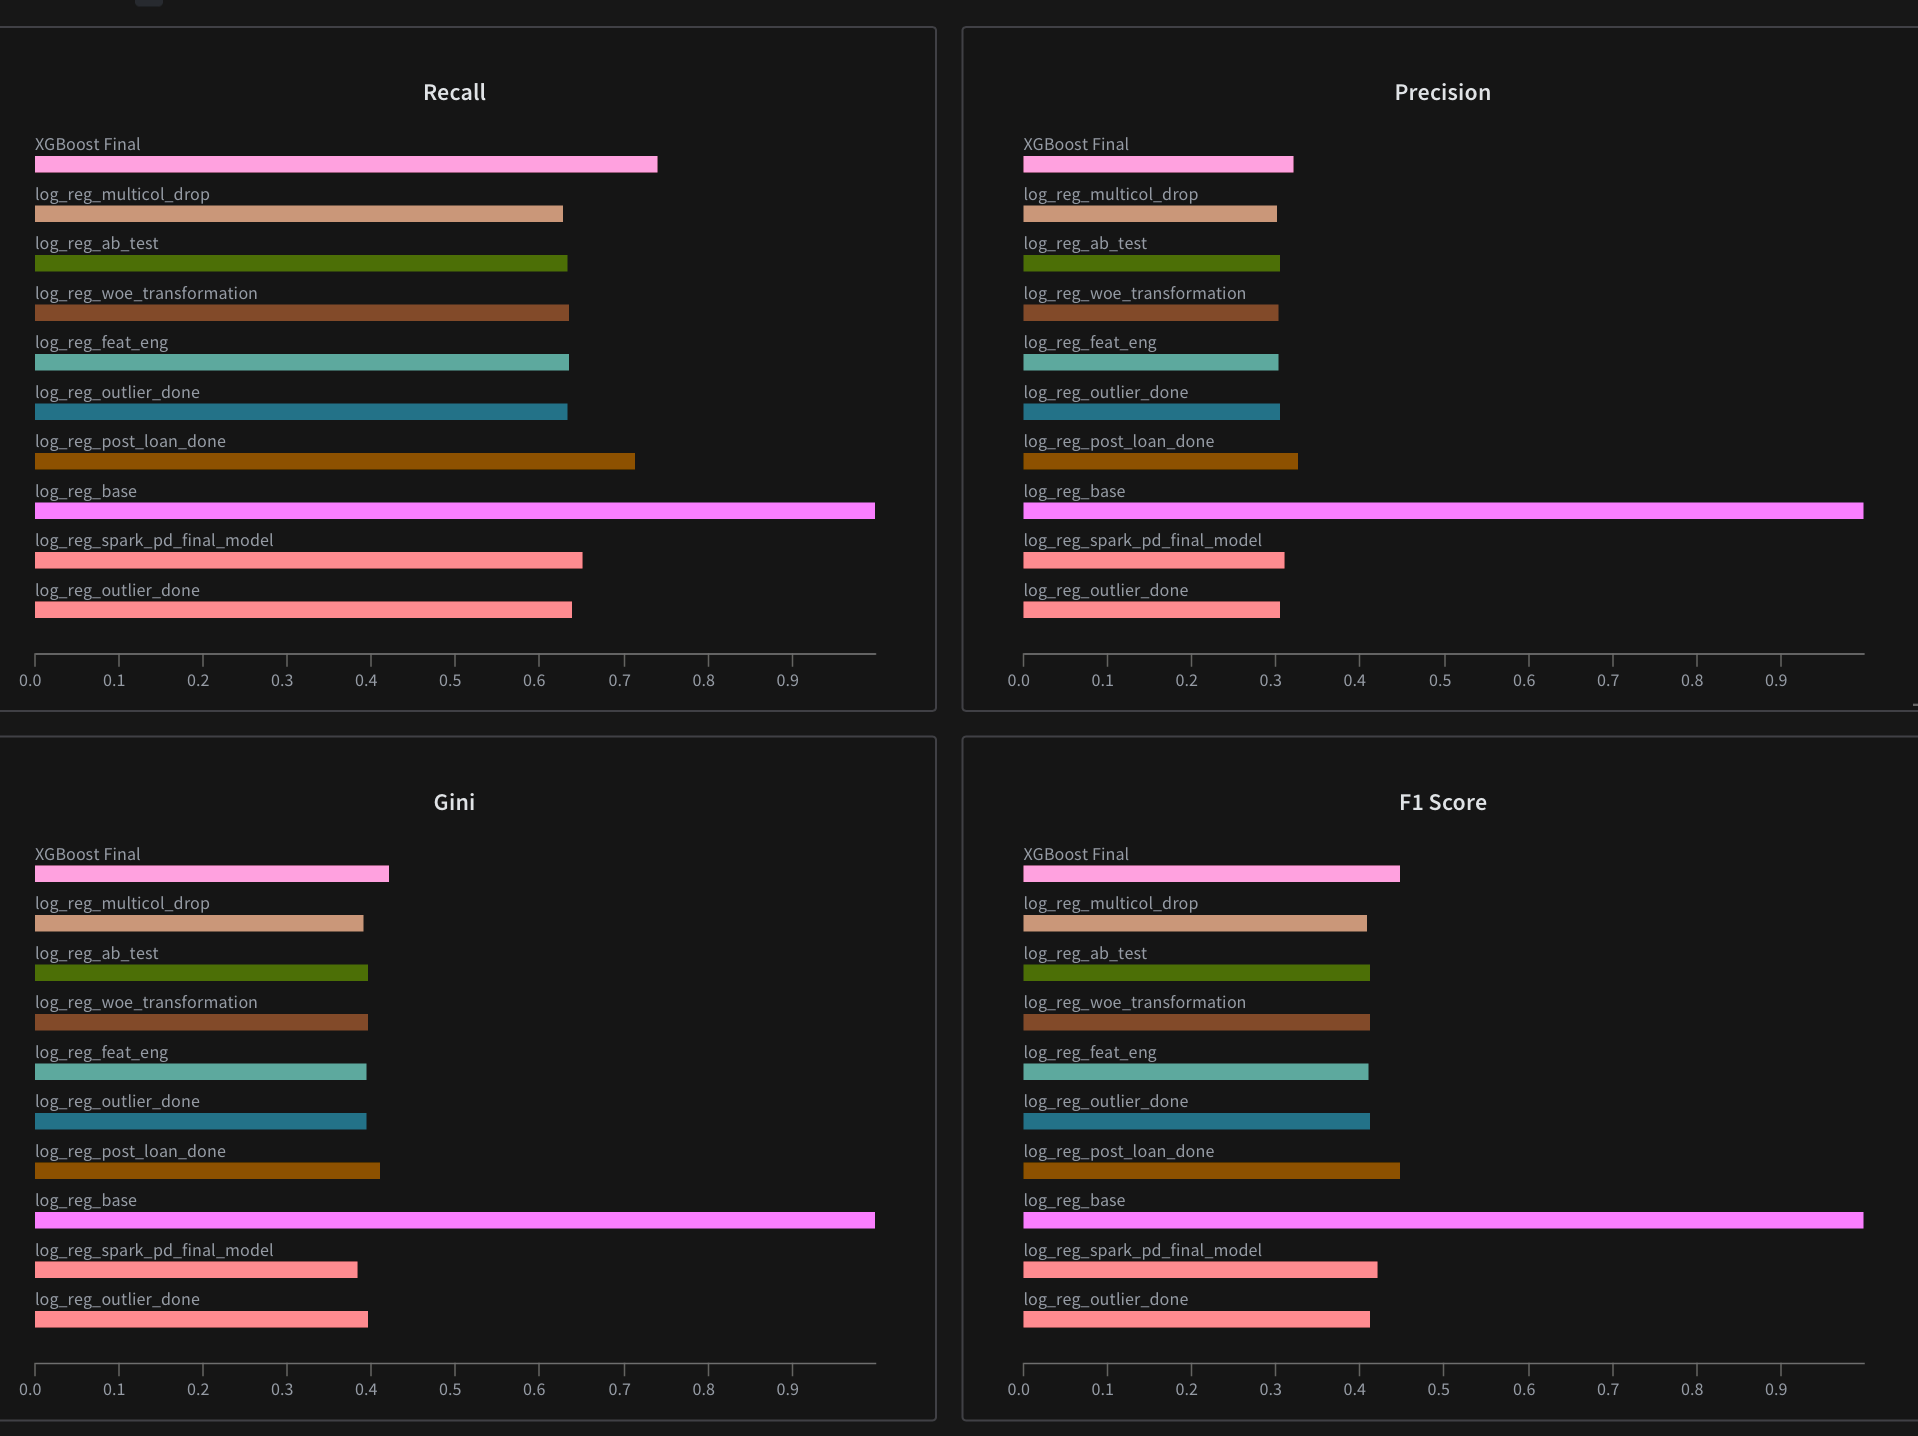

The XGBoost model performs better than all the logistic regression models across important metrics — Recall, Precision, Gini, and F1 Score.

- **Recall**: XGBoost catches more of the positive cases, which achieves our purpose, since in loan default prediction, the cost of missing risky loans is often much higher than cost of rejecting one.

- **Precision**: The model maintains a reasonable rate of correct positive predictions, so it keeps false alarms relatively lower than Logistic Regression.

- Gini coefficient: XGBoost scores higher, meaning it’s better at ranking risk.

- **F1 Score**: XGBoost model triumphs against Logistic Regression model as seen. It balances detecting risky cases while avoiding too many false positives.

**Conclusion**
XGBoost is clearly better at predicting loan risk compared to logistic regression models. This helps the business make more accurate lending decisions, reducing losses from bad loans while approving more good applicants.


# 6. SHAP Explanability

SHAP is a powerful tool for interpreting machine learning models. It helps us understand how each feature in our dataset influences the predictions made by your model. SHAP values are based on game theory and represent the contribution of each feature to a specific prediction, making models trustworthy. For example, in the case of credit risk modeling, SHAP can show which borrower characteristics (like income, loan amount, or credit history) most affect the probability of default predicted by the XGBoost model. This is crucial for regulatory compliance, and model validation.


/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


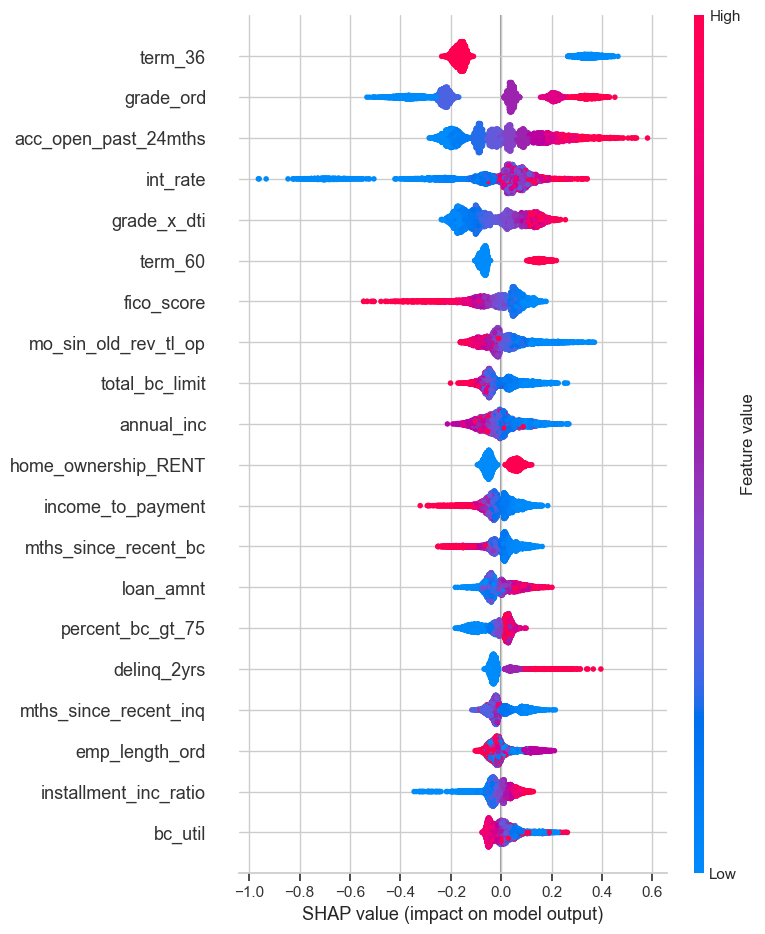

In [58]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(
    X_val_final.sample(5000, random_state=42)
)  # sample for speed

shap.summary_plot(shap_values, X_val_final.sample(5000, random_state=42))

Given the SHAP plot above, stakeholders and data scientists can validate thought processes, e.g. borrowers with higher income should have lower default rates. Features are ranked in descending order. Wide spread with blue dots signify that low values of a feature mean that borrowers tend to have much lower default rates, while wide spreads with red dots to the right signify high values of the corresponding feature tend to signify higher default rates. For example, from the plot above, higher number of accounts opened in the past few months tend to signify higher default rates. By understanding the SHAP plot, we can understand which features influecnce model output the most, providing the basis for the building of future challenger models / future feature engineering.

# 7. Project Conclusion

The final XGBoost model selected for this project achieved a recall of 74% and an overall accuracy of 60%. This indicates that the model is good at identifying the majority of positive cases (e.g., risky loans) while maintaining a reasonable overall correctness.

XGBoost is well suited for this loan prediction problem because:

- Higher recall: Compared to logistic regression on the same dataset, XGBoost consistently delivers better recall, making it more reliable in spotting risky loans, which may render disproportionate financial losses for banks / Lending Club investors.

- Flexible tuning: XGBoost offers many hyperparameter options to control overfitting and handle imbalanced data, which are common challenges in credit risk modeling. It fares better than limited Logistic Regression hyperparameters .

- Captures complex patterns: Its gradient boosting technique can model non-linear relationships in data, providing a stronger predictive capability than simpler linear models. This simplifies data preprocessing steps (which is complex / error prone in Logistic Regression Models, since they prefer monotonic trends between each feature and the target variable)

**Suggestions for Future Improvement**

- Expand exploratory data analysis (EDA): More detailed EDA could uncover new relevant features or data issues to improve the model.
- Increase training data: Using more data would help the ensemble model generalize better and improve performance.
- Enhance hyperparameter tuning: Use more computational resources
- Improve feature engineering techniques
